# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [45]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

ERROR: Could not find a version that satisfies the requirement torch==0.4.1 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1)
ERROR: No matching distribution found for torch==0.4.1


In [59]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    print(True)
else:
    from torch import FloatTensor, LongTensor
    print(False)

np.random.seed(42)

True


# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'.', 'CONJ', 'ADJ', 'PRON', 'ADV', 'NOUN', 'DET', 'VERB', 'PRT', 'NUM', 'ADP', 'X'}


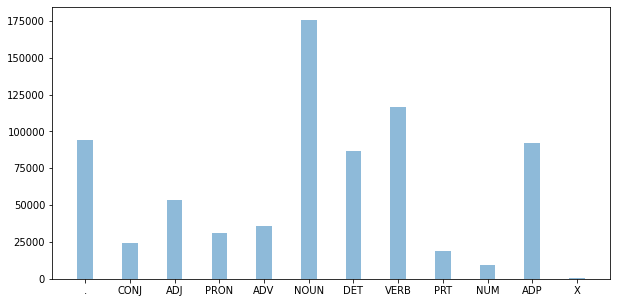

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [11]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [12]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [13]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [14]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        # <create layers>
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=False)
        self.linear = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        # <apply them>
        out = self.emb(inputs)
        out, _ = self.lstm(out)
        out = self.linear(out)
        
        return out

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [154]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

In [159]:
batch_size = 4
total_count = 0
current_count = 0

criterion = nn.CrossEntropyLoss()
loss = 0


for batch_num in range(len(X_test) // batch_size + 1):

  X_test_batch, y_test_batch = next(iterate_batches((X_test, y_test), batch_size))
  X_test_batch, y_test_batch = LongTensor(X_test_batch), LongTensor(y_test_batch)
  logits = model(X_test_batch)
  preds = torch.argmax(logits, 2)
  current_count += ((preds == y_test_batch).float()).sum()
  total_count += preds.sum()

  loss += criterion(logits.transpose(2, 1), y_test_batch)

loss = loss / (len(X_test) // batch_size + 1)
accuracy = current_count / total_count
print('current_count %d, total_count %d' % (current_count, total_count))
print('Accuracy: {:.3}'.format(accuracy))

current_count 26660, total_count 4779181
Accuracy: 0.00558


In [160]:

#<calc loss>
print('Loss : {:.3}'.format(loss))

Loss : 2.54


**Задание** Вставьте эти вычисление в функцию:

In [161]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                #<calc loss>
                loss = criterion(logits.transpose(2, 1), y_batch)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # <calc accuracy>
                mask = (y_batch != 0).float()
                preds = torch.argmax(logits, 2)
                cur_correct_count = ((preds == y_batch).float() * mask).sum()
                cur_sum_count = mask.sum()

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [162]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.31658, Accuracy = 71.66%: 100%|██████████| 572/572 [00:05<00:00, 112.27it/s]
[1 / 20]   Val: Loss = 0.10149, Accuracy = 84.96%: 100%|██████████| 13/13 [00:00<00:00, 71.14it/s]
[2 / 20] Train: Loss = 0.09918, Accuracy = 90.09%: 100%|██████████| 572/572 [00:05<00:00, 114.00it/s]
[2 / 20]   Val: Loss = 0.07005, Accuracy = 89.48%: 100%|██████████| 13/13 [00:00<00:00, 71.21it/s]
[3 / 20] Train: Loss = 0.06710, Accuracy = 93.28%: 100%|██████████| 572/572 [00:05<00:00, 106.45it/s]
[3 / 20]   Val: Loss = 0.06542, Accuracy = 91.19%: 100%|██████████| 13/13 [00:00<00:00, 70.95it/s]
[4 / 20] Train: Loss = 0.05113, Accuracy = 94.85%: 100%|██████████| 572/572 [00:05<00:00, 106.56it/s]
[4 / 20]   Val: Loss = 0.06140, Accuracy = 92.02%: 100%|██████████| 13/13 [00:00<00:00, 70.42it/s]
[5 / 20] Train: Loss = 0.04032, Accuracy = 95.84%: 100%|██████████| 572/572 [00:05<00:00, 104.52it/s]
[5 / 20]   Val: Loss = 0.06603, Accuracy = 92.52%: 100%|██████████| 13/13 [00:00<00:00, 72.37i

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [168]:
batch_size = 4
total_count = 0
current_count = 0

criterion = nn.CrossEntropyLoss()
loss = 0



for batch_num in range(len(X_test) // batch_size + 1):
  
  X_test_batch, y_test_batch = next(iterate_batches((X_test, y_test), batch_size))
  X_test_batch, y_test_batch = LongTensor(X_test_batch), LongTensor(y_test_batch)
  mask = (y_test_batch != 0).float()
  logits = model(X_test_batch)
  preds = torch.argmax(logits, 2)
  current_count += ((preds == y_test_batch ).float() * mask).sum()
  total_count += mask.sum()

  loss += criterion(logits.transpose(2, 1), y_test_batch)

loss = loss / (len(X_test) // batch_size + 1)
accuracy = current_count / total_count
print('current_count %d, total_count %d' % (current_count, total_count))
print('Accuracy: {:.3}'.format(accuracy))

current_count 277369, total_count 288722
Accuracy: 0.961


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [164]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        # <create layers>
        self.emb = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.linear = nn.Linear(lstm_hidden_dim*2, tagset_size)

    def forward(self, inputs):
        # <apply them>
        out = self.emb(inputs)
        out, _ = self.lstm(out)
        out = self.linear(out)
        
        return out

In [169]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.54876, Accuracy = 82.63%: 100%|██████████| 572/572 [00:06<00:00, 87.18it/s]
[1 / 20]   Val: Loss = 0.26970, Accuracy = 91.31%: 100%|██████████| 13/13 [00:00<00:00, 38.31it/s]
[2 / 20] Train: Loss = 0.20183, Accuracy = 93.53%: 100%|██████████| 572/572 [00:06<00:00, 93.75it/s] 
[2 / 20]   Val: Loss = 0.17399, Accuracy = 94.50%: 100%|██████████| 13/13 [00:00<00:00, 46.20it/s]
[3 / 20] Train: Loss = 0.12834, Accuracy = 96.00%: 100%|██████████| 572/572 [00:05<00:00, 99.62it/s] 
[3 / 20]   Val: Loss = 0.14105, Accuracy = 95.55%: 100%|██████████| 13/13 [00:00<00:00, 48.03it/s]
[4 / 20] Train: Loss = 0.08795, Accuracy = 97.29%: 100%|██████████| 572/572 [00:05<00:00, 97.81it/s]
[4 / 20]   Val: Loss = 0.13136, Accuracy = 96.00%: 100%|██████████| 13/13 [00:00<00:00, 47.24it/s]
[5 / 20] Train: Loss = 0.06078, Accuracy = 98.17%: 100%|██████████| 572/572 [00:05<00:00, 98.87it/s]
[5 / 20]   Val: Loss = 0.12146, Accuracy = 96.37%: 100%|██████████| 13/13 [00:00<00:00, 46.85it/s

In [170]:
batch_size = 4
total_count = 0
current_count = 0

criterion = nn.CrossEntropyLoss()
loss = 0

for batch_num in range(len(X_test) // batch_size + 1):
  
  X_test_batch, y_test_batch = next(iterate_batches((X_test, y_test), batch_size))
  X_test_batch, y_test_batch = LongTensor(X_test_batch), LongTensor(y_test_batch)
  mask = (y_test_batch != 0).float()
  logits = model(X_test_batch)
  preds = torch.argmax(logits, 2)
  current_count += ((preds == y_test_batch ).float() * mask).sum()
  total_count += mask.sum()

  loss += criterion(logits.transpose(2, 1), y_test_batch)

loss = loss / (len(X_test) // batch_size + 1)
accuracy = current_count / total_count
print('current_count %d, total_count %d' % (current_count, total_count))
print('Accuracy: {:.3}'.format(accuracy))

current_count 281967, total_count 291499
Accuracy: 0.967


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [24]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [125]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [195]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1, bidirectional=False):
        super().__init__()
        
        # <create me>
        self.emb = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count, bidirectional=bidirectional)
        self.linear = nn.Linear(lstm_hidden_dim + int(bidirectional) * lstm_hidden_dim, tagset_size)        

    def forward(self, inputs):
        # <use me>
        out = self.emb(inputs)
        out, _ = self.lstm(out)
        out = self.linear(out)
        
        return out

In [173]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=FloatTensor(embeddings),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.76113, Accuracy = 77.62%: 100%|██████████| 572/572 [00:03<00:00, 145.22it/s]
[1 / 20]   Val: Loss = 0.37465, Accuracy = 89.17%: 100%|██████████| 13/13 [00:00<00:00, 82.75it/s]
[2 / 20] Train: Loss = 0.28552, Accuracy = 91.45%: 100%|██████████| 572/572 [00:04<00:00, 142.88it/s]
[2 / 20]   Val: Loss = 0.25823, Accuracy = 92.21%: 100%|██████████| 13/13 [00:00<00:00, 87.69it/s]
[3 / 20] Train: Loss = 0.21119, Accuracy = 93.43%: 100%|██████████| 572/572 [00:04<00:00, 141.85it/s]
[3 / 20]   Val: Loss = 0.21116, Accuracy = 93.37%: 100%|██████████| 13/13 [00:00<00:00, 86.79it/s]
[4 / 20] Train: Loss = 0.17539, Accuracy = 94.42%: 100%|██████████| 572/572 [00:04<00:00, 140.44it/s]
[4 / 20]   Val: Loss = 0.18677, Accuracy = 94.02%: 100%|██████████| 13/13 [00:00<00:00, 83.38it/s]
[5 / 20] Train: Loss = 0.15387, Accuracy = 95.00%: 100%|██████████| 572/572 [00:04<00:00, 141.82it/s]
[5 / 20]   Val: Loss = 0.17189, Accuracy = 94.39%: 100%|██████████| 13/13 [00:00<00:00, 89.02i

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [187]:
# <calc test accuracy>
def calc_test_accuracy(model, test_data):
  correct = 0
  total = 0

  for sentence in test_data:
      sentence_inds = []
      sentence_tags = []
      
      for word, tag in sentence:

          try:
            sentence_tags.append(tag2ind[tag])   
          except:
            sentence_tags.append(0)
          try:
            sentence_inds.append(word2ind[word])
          except:
            sentence_inds.append(0)


      logits = model(LongTensor(sentence_inds))
      preds = torch.argmax(logits, 1)
      correct += (preds == LongTensor(sentence_tags)).float().sum()
      total += len(sentence_tags)
      

  accuracy = correct / total
  return accuracy

In [ ]:
lstm_hidden_dim_grid = [8, 16, 32, 64, 128]
lstm_layers_count_grid = [1, 2, 3]
batch_size_grid = [32, 64, 128]
bidirectional_grid = [False, True]
best_test_accuracy = None

for lstm_hidden_dim in lstm_hidden_dim_grid:
  for lstm_layers_count in lstm_layers_count_grid:
    for batch_size in batch_size_grid:
      for bidirectional in bidirectional_grid:


        model = LSTMTaggerWithPretrainedEmbs(
            embeddings=FloatTensor(embeddings),
            tagset_size=len(tag2ind),
            lstm_hidden_dim=lstm_hidden_dim,
            lstm_layers_count=lstm_layers_count,
            bidirectional=bidirectional
        ).cuda()

        criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
        optimizer = optim.Adam(model.parameters())

        fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20, batch_size=batch_size, val_data=(X_val, y_val), val_batch_size=512)
        
        test_accuracy = calc_test_accuracy(model, test_data)
        print('Accuracy: {:.3}'.format(test_accuracy))

        if best_test_accuracy is None or test_accuracy > best_test_accuracy:
          best_test_accuracy = test_accuracy
          print('lstm_hidden_dim = {}, lstm_layers_count = {}, batch_size = {}, bidirectional = {}'.format(lstm_hidden_dim, lstm_layers_count, batch_size, int(bidirectional)))
          print('NEW BEST_ACC = {}'.format(best_test_accuracy))


[1 / 20] Train: Loss = 1.16946, Accuracy = 68.71%: 100%|██████████| 1143/1143 [00:07<00:00, 153.11it/s]
[1 / 20]   Val: Loss = 0.68588, Accuracy = 79.21%: 100%|██████████| 13/13 [00:00<00:00, 117.98it/s]
[2 / 20] Train: Loss = 0.55354, Accuracy = 82.99%: 100%|██████████| 1143/1143 [00:07<00:00, 153.46it/s]
[2 / 20]   Val: Loss = 0.46885, Accuracy = 85.66%: 100%|██████████| 13/13 [00:00<00:00, 111.09it/s]
[3 / 20] Train: Loss = 0.39192, Accuracy = 88.22%: 100%|██████████| 1143/1143 [00:07<00:00, 154.19it/s]
[3 / 20]   Val: Loss = 0.36105, Accuracy = 89.09%: 100%|██████████| 13/13 [00:00<00:00, 110.15it/s]
[4 / 20] Train: Loss = 0.31468, Accuracy = 90.45%: 100%|██████████| 1143/1143 [00:07<00:00, 155.11it/s]
[4 / 20]   Val: Loss = 0.31066, Accuracy = 90.31%: 100%|██████████| 13/13 [00:00<00:00, 126.19it/s]
[5 / 20] Train: Loss = 0.27685, Accuracy = 91.30%: 100%|██████████| 1143/1143 [00:07<00:00, 152.89it/s]
[5 / 20]   Val: Loss = 0.28355, Accuracy = 91.00%: 100%|██████████| 13/13 [00:00

Accuracy: 0.932
lstm_hidden_dim = 8, lstm_layers_count = 1, batch_size = 32, bidirectional = 0
NEW BEST_ACC = 0.9319824576377869


[1 / 20] Train: Loss = 0.92549, Accuracy = 74.91%: 100%|██████████| 1143/1143 [00:08<00:00, 141.06it/s]
[1 / 20]   Val: Loss = 0.45677, Accuracy = 87.32%: 100%|██████████| 13/13 [00:00<00:00, 106.48it/s]
[2 / 20] Train: Loss = 0.34871, Accuracy = 90.58%: 100%|██████████| 1143/1143 [00:08<00:00, 140.15it/s]
[2 / 20]   Val: Loss = 0.30305, Accuracy = 91.68%: 100%|██████████| 13/13 [00:00<00:00, 108.09it/s]
[3 / 20] Train: Loss = 0.24954, Accuracy = 92.91%: 100%|██████████| 1143/1143 [00:08<00:00, 139.52it/s]
[3 / 20]   Val: Loss = 0.24377, Accuracy = 92.92%: 100%|██████████| 13/13 [00:00<00:00, 112.04it/s]
[4 / 20] Train: Loss = 0.20529, Accuracy = 93.91%: 100%|██████████| 1143/1143 [00:08<00:00, 141.06it/s]
[4 / 20]   Val: Loss = 0.21372, Accuracy = 93.57%: 100%|██████████| 13/13 [00:00<00:00, 109.09it/s]
[5 / 20] Train: Loss = 0.17942, Accuracy = 94.59%: 100%|██████████| 1143/1143 [00:08<00:00, 140.95it/s]
[5 / 20]   Val: Loss = 0.19233, Accuracy = 94.16%: 100%|██████████| 13/13 [00:00

Accuracy: 0.957
lstm_hidden_dim = 8, lstm_layers_count = 1, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9574928879737854


[1 / 20] Train: Loss = 1.62275, Accuracy = 54.07%: 100%|██████████| 572/572 [00:03<00:00, 145.37it/s]
[1 / 20]   Val: Loss = 1.07215, Accuracy = 69.51%: 100%|██████████| 13/13 [00:00<00:00, 121.17it/s]
[2 / 20] Train: Loss = 0.85551, Accuracy = 73.69%: 100%|██████████| 572/572 [00:03<00:00, 147.89it/s]
[2 / 20]   Val: Loss = 0.69449, Accuracy = 81.66%: 100%|██████████| 13/13 [00:00<00:00, 113.04it/s]
[3 / 20] Train: Loss = 0.57420, Accuracy = 84.78%: 100%|██████████| 572/572 [00:03<00:00, 148.07it/s]
[3 / 20]   Val: Loss = 0.50740, Accuracy = 85.84%: 100%|██████████| 13/13 [00:00<00:00, 126.92it/s]
[4 / 20] Train: Loss = 0.44579, Accuracy = 87.47%: 100%|██████████| 572/572 [00:03<00:00, 148.08it/s]
[4 / 20]   Val: Loss = 0.42378, Accuracy = 87.89%: 100%|██████████| 13/13 [00:00<00:00, 123.14it/s]
[5 / 20] Train: Loss = 0.38130, Accuracy = 89.23%: 100%|██████████| 572/572 [00:03<00:00, 145.57it/s]
[5 / 20]   Val: Loss = 0.37628, Accuracy = 89.06%: 100%|██████████| 13/13 [00:00<00:00, 11

Accuracy: 0.928


[1 / 20] Train: Loss = 1.28470, Accuracy = 62.87%: 100%|██████████| 572/572 [00:04<00:00, 132.23it/s]
[1 / 20]   Val: Loss = 0.69495, Accuracy = 80.10%: 100%|██████████| 13/13 [00:00<00:00, 112.71it/s]
[2 / 20] Train: Loss = 0.52887, Accuracy = 85.24%: 100%|██████████| 572/572 [00:04<00:00, 134.19it/s]
[2 / 20]   Val: Loss = 0.43501, Accuracy = 88.12%: 100%|██████████| 13/13 [00:00<00:00, 107.85it/s]
[3 / 20] Train: Loss = 0.36235, Accuracy = 90.28%: 100%|██████████| 572/572 [00:04<00:00, 135.46it/s]
[3 / 20]   Val: Loss = 0.33586, Accuracy = 90.79%: 100%|██████████| 13/13 [00:00<00:00, 109.34it/s]
[4 / 20] Train: Loss = 0.28886, Accuracy = 92.07%: 100%|██████████| 572/572 [00:04<00:00, 134.83it/s]
[4 / 20]   Val: Loss = 0.28278, Accuracy = 92.16%: 100%|██████████| 13/13 [00:00<00:00, 105.25it/s]
[5 / 20] Train: Loss = 0.24557, Accuracy = 93.15%: 100%|██████████| 572/572 [00:04<00:00, 134.93it/s]
[5 / 20]   Val: Loss = 0.24833, Accuracy = 92.94%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.955


[1 / 20] Train: Loss = 1.97363, Accuracy = 43.13%: 100%|██████████| 286/286 [00:02<00:00, 138.56it/s]
[1 / 20]   Val: Loss = 1.43685, Accuracy = 65.40%: 100%|██████████| 13/13 [00:00<00:00, 116.12it/s]
[2 / 20] Train: Loss = 1.18277, Accuracy = 68.83%: 100%|██████████| 286/286 [00:02<00:00, 137.04it/s]
[2 / 20]   Val: Loss = 0.98446, Accuracy = 73.49%: 100%|██████████| 13/13 [00:00<00:00, 116.70it/s]
[3 / 20] Train: Loss = 0.85687, Accuracy = 76.91%: 100%|██████████| 286/286 [00:02<00:00, 137.98it/s]
[3 / 20]   Val: Loss = 0.76000, Accuracy = 80.20%: 100%|██████████| 13/13 [00:00<00:00, 117.81it/s]
[4 / 20] Train: Loss = 0.67758, Accuracy = 82.00%: 100%|██████████| 286/286 [00:02<00:00, 135.75it/s]
[4 / 20]   Val: Loss = 0.62564, Accuracy = 82.69%: 100%|██████████| 13/13 [00:00<00:00, 115.56it/s]
[5 / 20] Train: Loss = 0.56690, Accuracy = 84.44%: 100%|██████████| 286/286 [00:02<00:00, 135.08it/s]
[5 / 20]   Val: Loss = 0.53993, Accuracy = 85.21%: 100%|██████████| 13/13 [00:00<00:00, 11

Accuracy: 0.92


[1 / 20] Train: Loss = 1.67631, Accuracy = 53.60%: 100%|██████████| 286/286 [00:02<00:00, 126.14it/s]
[1 / 20]   Val: Loss = 1.07216, Accuracy = 70.64%: 100%|██████████| 13/13 [00:00<00:00, 111.01it/s]
[2 / 20] Train: Loss = 0.84054, Accuracy = 77.45%: 100%|██████████| 286/286 [00:02<00:00, 124.84it/s]
[2 / 20]   Val: Loss = 0.68125, Accuracy = 81.30%: 100%|██████████| 13/13 [00:00<00:00, 107.83it/s]
[3 / 20] Train: Loss = 0.58627, Accuracy = 83.86%: 100%|██████████| 286/286 [00:02<00:00, 126.26it/s]
[3 / 20]   Val: Loss = 0.52219, Accuracy = 85.27%: 100%|██████████| 13/13 [00:00<00:00, 108.76it/s]
[4 / 20] Train: Loss = 0.46355, Accuracy = 87.16%: 100%|██████████| 286/286 [00:02<00:00, 124.31it/s]
[4 / 20]   Val: Loss = 0.43709, Accuracy = 87.68%: 100%|██████████| 13/13 [00:00<00:00, 104.95it/s]
[5 / 20] Train: Loss = 0.39163, Accuracy = 89.03%: 100%|██████████| 286/286 [00:02<00:00, 124.94it/s]
[5 / 20]   Val: Loss = 0.38027, Accuracy = 89.17%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.949


[1 / 20] Train: Loss = 1.77515, Accuracy = 40.38%: 100%|██████████| 1143/1143 [00:08<00:00, 138.20it/s]
[1 / 20]   Val: Loss = 1.22948, Accuracy = 63.25%: 100%|██████████| 13/13 [00:00<00:00, 110.00it/s]
[2 / 20] Train: Loss = 0.88448, Accuracy = 74.45%: 100%|██████████| 1143/1143 [00:08<00:00, 137.34it/s]
[2 / 20]   Val: Loss = 0.66491, Accuracy = 81.04%: 100%|██████████| 13/13 [00:00<00:00, 117.84it/s]
[3 / 20] Train: Loss = 0.52778, Accuracy = 85.24%: 100%|██████████| 1143/1143 [00:08<00:00, 136.60it/s]
[3 / 20]   Val: Loss = 0.45263, Accuracy = 87.75%: 100%|██████████| 13/13 [00:00<00:00, 114.59it/s]
[4 / 20] Train: Loss = 0.37900, Accuracy = 89.80%: 100%|██████████| 1143/1143 [00:08<00:00, 135.65it/s]
[4 / 20]   Val: Loss = 0.35788, Accuracy = 90.27%: 100%|██████████| 13/13 [00:00<00:00, 110.93it/s]
[5 / 20] Train: Loss = 0.31122, Accuracy = 91.39%: 100%|██████████| 1143/1143 [00:08<00:00, 133.37it/s]
[5 / 20]   Val: Loss = 0.31275, Accuracy = 91.18%: 100%|██████████| 13/13 [00:00

Accuracy: 0.936


[1 / 20] Train: Loss = 1.02867, Accuracy = 68.83%: 100%|██████████| 1143/1143 [00:09<00:00, 118.04it/s]
[1 / 20]   Val: Loss = 0.43610, Accuracy = 88.23%: 100%|██████████| 13/13 [00:00<00:00, 99.38it/s] 
[2 / 20] Train: Loss = 0.30915, Accuracy = 91.85%: 100%|██████████| 1143/1143 [00:09<00:00, 118.35it/s]
[2 / 20]   Val: Loss = 0.25864, Accuracy = 92.95%: 100%|██████████| 13/13 [00:00<00:00, 98.63it/s] 
[3 / 20] Train: Loss = 0.21184, Accuracy = 94.01%: 100%|██████████| 1143/1143 [00:09<00:00, 118.23it/s]
[3 / 20]   Val: Loss = 0.20830, Accuracy = 93.95%: 100%|██████████| 13/13 [00:00<00:00, 93.08it/s]
[4 / 20] Train: Loss = 0.17461, Accuracy = 94.87%: 100%|██████████| 1143/1143 [00:09<00:00, 118.00it/s]
[4 / 20]   Val: Loss = 0.18356, Accuracy = 94.55%: 100%|██████████| 13/13 [00:00<00:00, 94.35it/s]
[5 / 20] Train: Loss = 0.15435, Accuracy = 95.39%: 100%|██████████| 1143/1143 [00:09<00:00, 116.71it/s]
[5 / 20]   Val: Loss = 0.16914, Accuracy = 94.91%: 100%|██████████| 13/13 [00:00<0

Accuracy: 0.961
lstm_hidden_dim = 8, lstm_layers_count = 2, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9610939621925354


[1 / 20] Train: Loss = 2.05678, Accuracy = 30.56%: 100%|██████████| 572/572 [00:04<00:00, 132.78it/s]
[1 / 20]   Val: Loss = 1.53532, Accuracy = 57.54%: 100%|██████████| 13/13 [00:00<00:00, 108.75it/s]
[2 / 20] Train: Loss = 1.22927, Accuracy = 62.97%: 100%|██████████| 572/572 [00:04<00:00, 131.54it/s]
[2 / 20]   Val: Loss = 1.02038, Accuracy = 70.65%: 100%|██████████| 13/13 [00:00<00:00, 101.68it/s]
[3 / 20] Train: Loss = 0.76736, Accuracy = 78.36%: 100%|██████████| 572/572 [00:04<00:00, 132.52it/s]
[3 / 20]   Val: Loss = 0.60557, Accuracy = 83.53%: 100%|██████████| 13/13 [00:00<00:00, 108.18it/s]
[4 / 20] Train: Loss = 0.51588, Accuracy = 85.67%: 100%|██████████| 572/572 [00:04<00:00, 129.97it/s]
[4 / 20]   Val: Loss = 0.47168, Accuracy = 86.32%: 100%|██████████| 13/13 [00:00<00:00, 112.48it/s]
[5 / 20] Train: Loss = 0.41781, Accuracy = 87.88%: 100%|██████████| 572/572 [00:04<00:00, 131.03it/s]
[5 / 20]   Val: Loss = 0.40245, Accuracy = 88.51%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.93


[1 / 20] Train: Loss = 1.43941, Accuracy = 57.32%: 100%|██████████| 572/572 [00:04<00:00, 114.82it/s]
[1 / 20]   Val: Loss = 0.74000, Accuracy = 79.46%: 100%|██████████| 13/13 [00:00<00:00, 95.88it/s]
[2 / 20] Train: Loss = 0.51672, Accuracy = 86.06%: 100%|██████████| 572/572 [00:05<00:00, 114.01it/s]
[2 / 20]   Val: Loss = 0.39084, Accuracy = 89.76%: 100%|██████████| 13/13 [00:00<00:00, 96.02it/s] 
[3 / 20] Train: Loss = 0.30749, Accuracy = 92.09%: 100%|██████████| 572/572 [00:04<00:00, 115.47it/s]
[3 / 20]   Val: Loss = 0.27398, Accuracy = 92.87%: 100%|██████████| 13/13 [00:00<00:00, 95.96it/s]
[4 / 20] Train: Loss = 0.22717, Accuracy = 93.85%: 100%|██████████| 572/572 [00:05<00:00, 113.42it/s]
[4 / 20]   Val: Loss = 0.22241, Accuracy = 93.80%: 100%|██████████| 13/13 [00:00<00:00, 90.60it/s]
[5 / 20] Train: Loss = 0.18827, Accuracy = 94.67%: 100%|██████████| 572/572 [00:05<00:00, 114.18it/s]
[5 / 20]   Val: Loss = 0.19719, Accuracy = 94.34%: 100%|██████████| 13/13 [00:00<00:00, 92.67

Accuracy: 0.96


[1 / 20] Train: Loss = 2.24305, Accuracy = 20.42%: 100%|██████████| 286/286 [00:02<00:00, 122.96it/s]
[1 / 20]   Val: Loss = 1.95878, Accuracy = 32.54%: 100%|██████████| 13/13 [00:00<00:00, 113.99it/s]
[2 / 20] Train: Loss = 1.75487, Accuracy = 40.55%: 100%|██████████| 286/286 [00:02<00:00, 122.21it/s]
[2 / 20]   Val: Loss = 1.57233, Accuracy = 49.39%: 100%|██████████| 13/13 [00:00<00:00, 102.15it/s]
[3 / 20] Train: Loss = 1.35523, Accuracy = 64.44%: 100%|██████████| 286/286 [00:02<00:00, 121.76it/s]
[3 / 20]   Val: Loss = 1.14145, Accuracy = 69.66%: 100%|██████████| 13/13 [00:00<00:00, 110.23it/s]
[4 / 20] Train: Loss = 0.99565, Accuracy = 71.43%: 100%|██████████| 286/286 [00:02<00:00, 123.38it/s]
[4 / 20]   Val: Loss = 0.88181, Accuracy = 73.53%: 100%|██████████| 13/13 [00:00<00:00, 94.64it/s]
[5 / 20] Train: Loss = 0.79559, Accuracy = 75.62%: 100%|██████████| 286/286 [00:02<00:00, 123.14it/s]
[5 / 20]   Val: Loss = 0.72612, Accuracy = 78.48%: 100%|██████████| 13/13 [00:00<00:00, 106

Accuracy: 0.926


[1 / 20] Train: Loss = 1.77415, Accuracy = 44.38%: 100%|██████████| 286/286 [00:02<00:00, 106.95it/s]
[1 / 20]   Val: Loss = 1.11972, Accuracy = 69.28%: 100%|██████████| 13/13 [00:00<00:00, 96.39it/s]
[2 / 20] Train: Loss = 0.81101, Accuracy = 77.83%: 100%|██████████| 286/286 [00:02<00:00, 106.98it/s]
[2 / 20]   Val: Loss = 0.60411, Accuracy = 85.01%: 100%|██████████| 13/13 [00:00<00:00, 95.92it/s]
[3 / 20] Train: Loss = 0.48214, Accuracy = 87.67%: 100%|██████████| 286/286 [00:02<00:00, 105.38it/s]
[3 / 20]   Val: Loss = 0.40253, Accuracy = 89.65%: 100%|██████████| 13/13 [00:00<00:00, 93.44it/s]
[4 / 20] Train: Loss = 0.33306, Accuracy = 91.53%: 100%|██████████| 286/286 [00:02<00:00, 105.23it/s]
[4 / 20]   Val: Loss = 0.30513, Accuracy = 92.13%: 100%|██████████| 13/13 [00:00<00:00, 95.31it/s] 
[5 / 20] Train: Loss = 0.25779, Accuracy = 93.34%: 100%|██████████| 286/286 [00:02<00:00, 104.40it/s]
[5 / 20]   Val: Loss = 0.25078, Accuracy = 93.18%: 100%|██████████| 13/13 [00:00<00:00, 93.13

Accuracy: 0.959


[1 / 20] Train: Loss = 1.95213, Accuracy = 31.71%: 100%|██████████| 1143/1143 [00:09<00:00, 125.24it/s]
[1 / 20]   Val: Loss = 1.49652, Accuracy = 47.90%: 100%|██████████| 13/13 [00:00<00:00, 104.53it/s]
[2 / 20] Train: Loss = 1.16018, Accuracy = 60.93%: 100%|██████████| 1143/1143 [00:09<00:00, 124.64it/s]
[2 / 20]   Val: Loss = 0.81331, Accuracy = 77.64%: 100%|██████████| 13/13 [00:00<00:00, 102.27it/s]
[3 / 20] Train: Loss = 0.62298, Accuracy = 81.69%: 100%|██████████| 1143/1143 [00:09<00:00, 125.15it/s]
[3 / 20]   Val: Loss = 0.50836, Accuracy = 84.14%: 100%|██████████| 13/13 [00:00<00:00, 102.17it/s]
[4 / 20] Train: Loss = 0.42509, Accuracy = 87.48%: 100%|██████████| 1143/1143 [00:09<00:00, 123.91it/s]
[4 / 20]   Val: Loss = 0.39226, Accuracy = 88.72%: 100%|██████████| 13/13 [00:00<00:00, 93.58it/s]
[5 / 20] Train: Loss = 0.34330, Accuracy = 90.50%: 100%|██████████| 1143/1143 [00:09<00:00, 123.14it/s]
[5 / 20]   Val: Loss = 0.34381, Accuracy = 90.73%: 100%|██████████| 13/13 [00:00<

Accuracy: 0.937


[1 / 20] Train: Loss = 1.15877, Accuracy = 63.89%: 100%|██████████| 1143/1143 [00:11<00:00, 103.13it/s]
[1 / 20]   Val: Loss = 0.47536, Accuracy = 87.21%: 100%|██████████| 13/13 [00:00<00:00, 85.35it/s]
[2 / 20] Train: Loss = 0.33201, Accuracy = 91.41%: 100%|██████████| 1143/1143 [00:11<00:00, 102.96it/s]
[2 / 20]   Val: Loss = 0.26715, Accuracy = 92.95%: 100%|██████████| 13/13 [00:00<00:00, 91.39it/s]
[3 / 20] Train: Loss = 0.21501, Accuracy = 94.25%: 100%|██████████| 1143/1143 [00:11<00:00, 102.41it/s]
[3 / 20]   Val: Loss = 0.21071, Accuracy = 94.19%: 100%|██████████| 13/13 [00:00<00:00, 92.49it/s]
[4 / 20] Train: Loss = 0.17488, Accuracy = 95.11%: 100%|██████████| 1143/1143 [00:11<00:00, 102.53it/s]
[4 / 20]   Val: Loss = 0.18388, Accuracy = 94.75%: 100%|██████████| 13/13 [00:00<00:00, 85.84it/s]
[5 / 20] Train: Loss = 0.15370, Accuracy = 95.56%: 100%|██████████| 1143/1143 [00:11<00:00, 102.01it/s]
[5 / 20]   Val: Loss = 0.16777, Accuracy = 95.06%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.963
lstm_hidden_dim = 8, lstm_layers_count = 3, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9634659886360168


[1 / 20] Train: Loss = 2.11903, Accuracy = 25.64%: 100%|██████████| 572/572 [00:04<00:00, 115.84it/s]
[1 / 20]   Val: Loss = 1.78718, Accuracy = 38.36%: 100%|██████████| 13/13 [00:00<00:00, 102.02it/s]
[2 / 20] Train: Loss = 1.60105, Accuracy = 47.43%: 100%|██████████| 572/572 [00:04<00:00, 120.19it/s]
[2 / 20]   Val: Loss = 1.39384, Accuracy = 58.55%: 100%|██████████| 13/13 [00:00<00:00, 99.47it/s] 
[3 / 20] Train: Loss = 1.20279, Accuracy = 65.54%: 100%|██████████| 572/572 [00:04<00:00, 119.46it/s]
[3 / 20]   Val: Loss = 1.04568, Accuracy = 71.35%: 100%|██████████| 13/13 [00:00<00:00, 96.51it/s]
[4 / 20] Train: Loss = 0.89331, Accuracy = 73.89%: 100%|██████████| 572/572 [00:04<00:00, 117.28it/s]
[4 / 20]   Val: Loss = 0.76761, Accuracy = 77.45%: 100%|██████████| 13/13 [00:00<00:00, 102.87it/s]
[5 / 20] Train: Loss = 0.64768, Accuracy = 80.87%: 100%|██████████| 572/572 [00:04<00:00, 118.45it/s]
[5 / 20]   Val: Loss = 0.55881, Accuracy = 85.25%: 100%|██████████| 13/13 [00:00<00:00, 98.

Accuracy: 0.931


[1 / 20] Train: Loss = 1.65718, Accuracy = 47.16%: 100%|██████████| 572/572 [00:05<00:00, 97.79it/s]
[1 / 20]   Val: Loss = 0.88837, Accuracy = 73.81%: 100%|██████████| 13/13 [00:00<00:00, 83.33it/s]
[2 / 20] Train: Loss = 0.58919, Accuracy = 83.25%: 100%|██████████| 572/572 [00:05<00:00, 97.86it/s]
[2 / 20]   Val: Loss = 0.43035, Accuracy = 88.37%: 100%|██████████| 13/13 [00:00<00:00, 88.85it/s]
[3 / 20] Train: Loss = 0.33346, Accuracy = 91.40%: 100%|██████████| 572/572 [00:05<00:00, 98.11it/s]
[3 / 20]   Val: Loss = 0.28852, Accuracy = 92.66%: 100%|██████████| 13/13 [00:00<00:00, 86.18it/s]
[4 / 20] Train: Loss = 0.23481, Accuracy = 94.00%: 100%|██████████| 572/572 [00:05<00:00, 98.79it/s] 
[4 / 20]   Val: Loss = 0.23120, Accuracy = 93.91%: 100%|██████████| 13/13 [00:00<00:00, 87.74it/s]
[5 / 20] Train: Loss = 0.19383, Accuracy = 94.83%: 100%|██████████| 572/572 [00:05<00:00, 98.05it/s]
[5 / 20]   Val: Loss = 0.20370, Accuracy = 94.44%: 100%|██████████| 13/13 [00:00<00:00, 83.07it/s]

Accuracy: 0.961


[1 / 20] Train: Loss = 2.22293, Accuracy = 23.12%: 100%|██████████| 286/286 [00:02<00:00, 113.59it/s]
[1 / 20]   Val: Loss = 2.10540, Accuracy = 23.75%: 100%|██████████| 13/13 [00:00<00:00, 101.03it/s]
[2 / 20] Train: Loss = 1.87874, Accuracy = 36.11%: 100%|██████████| 286/286 [00:02<00:00, 110.45it/s]
[2 / 20]   Val: Loss = 1.57949, Accuracy = 53.62%: 100%|██████████| 13/13 [00:00<00:00, 104.43it/s]
[3 / 20] Train: Loss = 1.29671, Accuracy = 61.80%: 100%|██████████| 286/286 [00:02<00:00, 111.13it/s]
[3 / 20]   Val: Loss = 1.07828, Accuracy = 68.32%: 100%|██████████| 13/13 [00:00<00:00, 97.85it/s] 
[4 / 20] Train: Loss = 0.93980, Accuracy = 71.60%: 100%|██████████| 286/286 [00:02<00:00, 111.28it/s]
[4 / 20]   Val: Loss = 0.82908, Accuracy = 76.57%: 100%|██████████| 13/13 [00:00<00:00, 96.86it/s] 
[5 / 20] Train: Loss = 0.73533, Accuracy = 80.22%: 100%|██████████| 286/286 [00:02<00:00, 111.16it/s]
[5 / 20]   Val: Loss = 0.67396, Accuracy = 81.79%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.927


[1 / 20] Train: Loss = 2.10875, Accuracy = 27.56%: 100%|██████████| 286/286 [00:03<00:00, 94.23it/s]
[1 / 20]   Val: Loss = 1.66778, Accuracy = 45.23%: 100%|██████████| 13/13 [00:00<00:00, 90.07it/s]
[2 / 20] Train: Loss = 1.30220, Accuracy = 57.77%: 100%|██████████| 286/286 [00:03<00:00, 93.68it/s]
[2 / 20]   Val: Loss = 1.02855, Accuracy = 65.13%: 100%|██████████| 13/13 [00:00<00:00, 94.53it/s]
[3 / 20] Train: Loss = 0.80455, Accuracy = 76.39%: 100%|██████████| 286/286 [00:03<00:00, 93.01it/s]
[3 / 20]   Val: Loss = 0.61213, Accuracy = 84.55%: 100%|██████████| 13/13 [00:00<00:00, 88.10it/s]
[4 / 20] Train: Loss = 0.50219, Accuracy = 87.76%: 100%|██████████| 286/286 [00:03<00:00, 94.34it/s]
[4 / 20]   Val: Loss = 0.43492, Accuracy = 89.29%: 100%|██████████| 13/13 [00:00<00:00, 92.88it/s]
[5 / 20] Train: Loss = 0.36485, Accuracy = 91.04%: 100%|██████████| 286/286 [00:03<00:00, 92.43it/s]
[5 / 20]   Val: Loss = 0.33015, Accuracy = 91.66%: 100%|██████████| 13/13 [00:00<00:00, 100.41it/s]

Accuracy: 0.958


[1 / 20] Train: Loss = 0.91850, Accuracy = 74.73%: 100%|██████████| 1143/1143 [00:08<00:00, 139.49it/s]
[1 / 20]   Val: Loss = 0.46651, Accuracy = 86.65%: 100%|██████████| 13/13 [00:00<00:00, 113.48it/s]
[2 / 20] Train: Loss = 0.36629, Accuracy = 89.47%: 100%|██████████| 1143/1143 [00:08<00:00, 139.98it/s]
[2 / 20]   Val: Loss = 0.32913, Accuracy = 90.04%: 100%|██████████| 13/13 [00:00<00:00, 103.16it/s]
[3 / 20] Train: Loss = 0.27632, Accuracy = 91.38%: 100%|██████████| 1143/1143 [00:08<00:00, 140.06it/s]
[3 / 20]   Val: Loss = 0.27294, Accuracy = 91.39%: 100%|██████████| 13/13 [00:00<00:00, 112.78it/s]
[4 / 20] Train: Loss = 0.23332, Accuracy = 92.41%: 100%|██████████| 1143/1143 [00:08<00:00, 142.81it/s]
[4 / 20]   Val: Loss = 0.24384, Accuracy = 92.17%: 100%|██████████| 13/13 [00:00<00:00, 108.48it/s]
[5 / 20] Train: Loss = 0.20774, Accuracy = 93.10%: 100%|██████████| 1143/1143 [00:08<00:00, 140.44it/s]
[5 / 20]   Val: Loss = 0.22371, Accuracy = 92.66%: 100%|██████████| 13/13 [00:00

Accuracy: 0.944


[1 / 20] Train: Loss = 0.67302, Accuracy = 81.40%: 100%|██████████| 1143/1143 [00:08<00:00, 127.92it/s]
[1 / 20]   Val: Loss = 0.30652, Accuracy = 91.35%: 100%|██████████| 13/13 [00:00<00:00, 97.93it/s] 
[2 / 20] Train: Loss = 0.23414, Accuracy = 93.17%: 100%|██████████| 1143/1143 [00:08<00:00, 129.51it/s]
[2 / 20]   Val: Loss = 0.21252, Accuracy = 93.63%: 100%|██████████| 13/13 [00:00<00:00, 109.85it/s]
[3 / 20] Train: Loss = 0.17146, Accuracy = 94.84%: 100%|██████████| 1143/1143 [00:08<00:00, 128.60it/s]
[3 / 20]   Val: Loss = 0.17403, Accuracy = 94.66%: 100%|██████████| 13/13 [00:00<00:00, 103.52it/s]
[4 / 20] Train: Loss = 0.14187, Accuracy = 95.70%: 100%|██████████| 1143/1143 [00:08<00:00, 127.52it/s]
[4 / 20]   Val: Loss = 0.15351, Accuracy = 95.31%: 100%|██████████| 13/13 [00:00<00:00, 98.66it/s] 
[5 / 20] Train: Loss = 0.12467, Accuracy = 96.18%: 100%|██████████| 1143/1143 [00:08<00:00, 128.28it/s]
[5 / 20]   Val: Loss = 0.14172, Accuracy = 95.60%: 100%|██████████| 13/13 [00:00

Accuracy: 0.965
lstm_hidden_dim = 16, lstm_layers_count = 1, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9652045965194702


[1 / 20] Train: Loss = 1.24352, Accuracy = 65.85%: 100%|██████████| 572/572 [00:04<00:00, 135.30it/s]
[1 / 20]   Val: Loss = 0.66652, Accuracy = 81.12%: 100%|██████████| 13/13 [00:00<00:00, 107.40it/s]
[2 / 20] Train: Loss = 0.52243, Accuracy = 85.26%: 100%|██████████| 572/572 [00:04<00:00, 135.73it/s]
[2 / 20]   Val: Loss = 0.44138, Accuracy = 87.42%: 100%|██████████| 13/13 [00:00<00:00, 111.73it/s]
[3 / 20] Train: Loss = 0.37463, Accuracy = 89.36%: 100%|██████████| 572/572 [00:04<00:00, 137.76it/s]
[3 / 20]   Val: Loss = 0.34980, Accuracy = 89.87%: 100%|██████████| 13/13 [00:00<00:00, 110.19it/s]
[4 / 20] Train: Loss = 0.30367, Accuracy = 91.03%: 100%|██████████| 572/572 [00:04<00:00, 138.52it/s]
[4 / 20]   Val: Loss = 0.29991, Accuracy = 91.05%: 100%|██████████| 13/13 [00:00<00:00, 108.24it/s]
[5 / 20] Train: Loss = 0.26183, Accuracy = 91.96%: 100%|██████████| 572/572 [00:04<00:00, 137.66it/s]
[5 / 20]   Val: Loss = 0.26885, Accuracy = 91.73%: 100%|██████████| 13/13 [00:00<00:00, 11

Accuracy: 0.944


[1 / 20] Train: Loss = 0.93922, Accuracy = 74.16%: 100%|██████████| 572/572 [00:04<00:00, 121.96it/s]
[1 / 20]   Val: Loss = 0.43212, Accuracy = 87.79%: 100%|██████████| 13/13 [00:00<00:00, 95.60it/s]
[2 / 20] Train: Loss = 0.32617, Accuracy = 91.11%: 100%|██████████| 572/572 [00:04<00:00, 125.39it/s]
[2 / 20]   Val: Loss = 0.28068, Accuracy = 92.02%: 100%|██████████| 13/13 [00:00<00:00, 99.95it/s] 
[3 / 20] Train: Loss = 0.23011, Accuracy = 93.45%: 100%|██████████| 572/572 [00:04<00:00, 125.29it/s]
[3 / 20]   Val: Loss = 0.22305, Accuracy = 93.59%: 100%|██████████| 13/13 [00:00<00:00, 102.57it/s]
[4 / 20] Train: Loss = 0.18606, Accuracy = 94.59%: 100%|██████████| 572/572 [00:04<00:00, 124.62it/s]
[4 / 20]   Val: Loss = 0.19250, Accuracy = 94.37%: 100%|██████████| 13/13 [00:00<00:00, 95.65it/s]
[5 / 20] Train: Loss = 0.15996, Accuracy = 95.28%: 100%|██████████| 572/572 [00:04<00:00, 123.00it/s]
[5 / 20]   Val: Loss = 0.17277, Accuracy = 94.85%: 100%|██████████| 13/13 [00:00<00:00, 96.7

Accuracy: 0.964


[1 / 20] Train: Loss = 1.70284, Accuracy = 50.90%: 100%|██████████| 286/286 [00:02<00:00, 128.93it/s]
[1 / 20]   Val: Loss = 1.10662, Accuracy = 68.48%: 100%|██████████| 13/13 [00:00<00:00, 107.57it/s]
[2 / 20] Train: Loss = 0.86602, Accuracy = 75.01%: 100%|██████████| 286/286 [00:02<00:00, 126.03it/s]
[2 / 20]   Val: Loss = 0.70128, Accuracy = 80.24%: 100%|██████████| 13/13 [00:00<00:00, 107.61it/s]
[3 / 20] Train: Loss = 0.59571, Accuracy = 83.49%: 100%|██████████| 286/286 [00:02<00:00, 125.81it/s]
[3 / 20]   Val: Loss = 0.53361, Accuracy = 84.97%: 100%|██████████| 13/13 [00:00<00:00, 113.49it/s]
[4 / 20] Train: Loss = 0.46596, Accuracy = 87.32%: 100%|██████████| 286/286 [00:02<00:00, 125.11it/s]
[4 / 20]   Val: Loss = 0.43677, Accuracy = 88.09%: 100%|██████████| 13/13 [00:00<00:00, 108.12it/s]
[5 / 20] Train: Loss = 0.38718, Accuracy = 89.55%: 100%|██████████| 286/286 [00:02<00:00, 130.10it/s]
[5 / 20]   Val: Loss = 0.37787, Accuracy = 89.60%: 100%|██████████| 13/13 [00:00<00:00, 11

Accuracy: 0.937


[1 / 20] Train: Loss = 1.38985, Accuracy = 61.81%: 100%|██████████| 286/286 [00:02<00:00, 115.74it/s]
[1 / 20]   Val: Loss = 0.71890, Accuracy = 79.95%: 100%|██████████| 13/13 [00:00<00:00, 106.91it/s]
[2 / 20] Train: Loss = 0.52084, Accuracy = 86.09%: 100%|██████████| 286/286 [00:02<00:00, 113.91it/s]
[2 / 20]   Val: Loss = 0.41340, Accuracy = 88.64%: 100%|██████████| 13/13 [00:00<00:00, 96.96it/s]
[3 / 20] Train: Loss = 0.34422, Accuracy = 90.71%: 100%|██████████| 286/286 [00:02<00:00, 115.92it/s]
[3 / 20]   Val: Loss = 0.31829, Accuracy = 91.17%: 100%|██████████| 13/13 [00:00<00:00, 97.27it/s]
[4 / 20] Train: Loss = 0.27279, Accuracy = 92.40%: 100%|██████████| 286/286 [00:02<00:00, 116.58it/s]
[4 / 20]   Val: Loss = 0.26651, Accuracy = 92.38%: 100%|██████████| 13/13 [00:00<00:00, 97.69it/s] 
[5 / 20] Train: Loss = 0.23041, Accuracy = 93.37%: 100%|██████████| 286/286 [00:02<00:00, 112.96it/s]
[5 / 20]   Val: Loss = 0.23325, Accuracy = 93.10%: 100%|██████████| 13/13 [00:00<00:00, 102.

Accuracy: 0.961


[1 / 20] Train: Loss = 1.02519, Accuracy = 69.67%: 100%|██████████| 1143/1143 [00:08<00:00, 130.07it/s]
[1 / 20]   Val: Loss = 0.45543, Accuracy = 86.66%: 100%|██████████| 13/13 [00:00<00:00, 101.14it/s]
[2 / 20] Train: Loss = 0.32935, Accuracy = 90.73%: 100%|██████████| 1143/1143 [00:08<00:00, 129.96it/s]
[2 / 20]   Val: Loss = 0.28476, Accuracy = 91.54%: 100%|██████████| 13/13 [00:00<00:00, 106.27it/s]
[3 / 20] Train: Loss = 0.23739, Accuracy = 92.98%: 100%|██████████| 1143/1143 [00:08<00:00, 130.23it/s]
[3 / 20]   Val: Loss = 0.23935, Accuracy = 92.73%: 100%|██████████| 13/13 [00:00<00:00, 103.98it/s]
[4 / 20] Train: Loss = 0.20114, Accuracy = 93.79%: 100%|██████████| 1143/1143 [00:08<00:00, 131.56it/s]
[4 / 20]   Val: Loss = 0.21350, Accuracy = 93.30%: 100%|██████████| 13/13 [00:00<00:00, 104.73it/s]
[5 / 20] Train: Loss = 0.18108, Accuracy = 94.24%: 100%|██████████| 1143/1143 [00:08<00:00, 128.44it/s]
[5 / 20]   Val: Loss = 0.19859, Accuracy = 93.73%: 100%|██████████| 13/13 [00:00

Accuracy: 0.948


[1 / 20] Train: Loss = 0.65105, Accuracy = 80.62%: 100%|██████████| 1143/1143 [00:10<00:00, 109.02it/s]
[1 / 20]   Val: Loss = 0.24683, Accuracy = 93.06%: 100%|██████████| 13/13 [00:00<00:00, 89.13it/s]
[2 / 20] Train: Loss = 0.17771, Accuracy = 94.80%: 100%|██████████| 1143/1143 [00:10<00:00, 108.98it/s]
[2 / 20]   Val: Loss = 0.16765, Accuracy = 94.91%: 100%|██████████| 13/13 [00:00<00:00, 90.18it/s]
[3 / 20] Train: Loss = 0.13099, Accuracy = 95.98%: 100%|██████████| 1143/1143 [00:10<00:00, 108.92it/s]
[3 / 20]   Val: Loss = 0.14243, Accuracy = 95.63%: 100%|██████████| 13/13 [00:00<00:00, 88.57it/s]
[4 / 20] Train: Loss = 0.11155, Accuracy = 96.56%: 100%|██████████| 1143/1143 [00:10<00:00, 109.00it/s]
[4 / 20]   Val: Loss = 0.12834, Accuracy = 96.00%: 100%|██████████| 13/13 [00:00<00:00, 92.15it/s]
[5 / 20] Train: Loss = 0.10040, Accuracy = 96.88%: 100%|██████████| 1143/1143 [00:10<00:00, 110.20it/s]
[5 / 20]   Val: Loss = 0.12081, Accuracy = 96.20%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.968
lstm_hidden_dim = 16, lstm_layers_count = 2, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9680861234664917


[1 / 20] Train: Loss = 1.54761, Accuracy = 52.27%: 100%|██████████| 572/572 [00:04<00:00, 122.98it/s]
[1 / 20]   Val: Loss = 0.85326, Accuracy = 74.75%: 100%|██████████| 13/13 [00:00<00:00, 100.64it/s]
[2 / 20] Train: Loss = 0.65239, Accuracy = 79.49%: 100%|██████████| 572/572 [00:04<00:00, 123.05it/s]
[2 / 20]   Val: Loss = 0.50210, Accuracy = 86.45%: 100%|██████████| 13/13 [00:00<00:00, 105.31it/s]
[3 / 20] Train: Loss = 0.39148, Accuracy = 89.91%: 100%|██████████| 572/572 [00:04<00:00, 125.71it/s]
[3 / 20]   Val: Loss = 0.33751, Accuracy = 91.18%: 100%|██████████| 13/13 [00:00<00:00, 100.07it/s]
[4 / 20] Train: Loss = 0.27973, Accuracy = 92.50%: 100%|██████████| 572/572 [00:04<00:00, 124.50it/s]
[4 / 20]   Val: Loss = 0.26988, Accuracy = 92.43%: 100%|██████████| 13/13 [00:00<00:00, 104.95it/s]
[5 / 20] Train: Loss = 0.23027, Accuracy = 93.41%: 100%|██████████| 572/572 [00:04<00:00, 127.34it/s]
[5 / 20]   Val: Loss = 0.23749, Accuracy = 92.90%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.945


[1 / 20] Train: Loss = 1.00545, Accuracy = 70.27%: 100%|██████████| 572/572 [00:05<00:00, 104.66it/s]
[1 / 20]   Val: Loss = 0.38855, Accuracy = 89.65%: 100%|██████████| 13/13 [00:00<00:00, 91.64it/s]
[2 / 20] Train: Loss = 0.26647, Accuracy = 93.04%: 100%|██████████| 572/572 [00:05<00:00, 105.67it/s]
[2 / 20]   Val: Loss = 0.21851, Accuracy = 93.93%: 100%|██████████| 13/13 [00:00<00:00, 89.24it/s]
[3 / 20] Train: Loss = 0.17259, Accuracy = 95.05%: 100%|██████████| 572/572 [00:05<00:00, 104.77it/s]
[3 / 20]   Val: Loss = 0.17033, Accuracy = 94.95%: 100%|██████████| 13/13 [00:00<00:00, 88.38it/s]
[4 / 20] Train: Loss = 0.13788, Accuracy = 95.88%: 100%|██████████| 572/572 [00:05<00:00, 103.61it/s]
[4 / 20]   Val: Loss = 0.14857, Accuracy = 95.48%: 100%|██████████| 13/13 [00:00<00:00, 94.38it/s]
[5 / 20] Train: Loss = 0.11934, Accuracy = 96.38%: 100%|██████████| 572/572 [00:05<00:00, 103.94it/s]
[5 / 20]   Val: Loss = 0.13560, Accuracy = 95.82%: 100%|██████████| 13/13 [00:00<00:00, 89.50i

Accuracy: 0.968
lstm_hidden_dim = 16, lstm_layers_count = 2, batch_size = 64, bidirectional = 1
NEW BEST_ACC = 0.9682513475418091


[1 / 20] Train: Loss = 2.05186, Accuracy = 30.11%: 100%|██████████| 286/286 [00:02<00:00, 117.84it/s]
[1 / 20]   Val: Loss = 1.64401, Accuracy = 53.08%: 100%|██████████| 13/13 [00:00<00:00, 89.77it/s]
[2 / 20] Train: Loss = 1.16123, Accuracy = 67.59%: 100%|██████████| 286/286 [00:02<00:00, 115.84it/s]
[2 / 20]   Val: Loss = 0.84356, Accuracy = 75.89%: 100%|██████████| 13/13 [00:00<00:00, 103.45it/s]
[3 / 20] Train: Loss = 0.68574, Accuracy = 80.77%: 100%|██████████| 286/286 [00:02<00:00, 115.06it/s]
[3 / 20]   Val: Loss = 0.57337, Accuracy = 84.60%: 100%|██████████| 13/13 [00:00<00:00, 103.84it/s]
[4 / 20] Train: Loss = 0.48193, Accuracy = 86.95%: 100%|██████████| 286/286 [00:02<00:00, 116.49it/s]
[4 / 20]   Val: Loss = 0.43027, Accuracy = 88.22%: 100%|██████████| 13/13 [00:00<00:00, 97.01it/s]
[5 / 20] Train: Loss = 0.37160, Accuracy = 89.98%: 100%|██████████| 286/286 [00:02<00:00, 117.51it/s]
[5 / 20]   Val: Loss = 0.35145, Accuracy = 90.34%: 100%|██████████| 13/13 [00:00<00:00, 105.

Accuracy: 0.943


[1 / 20] Train: Loss = 1.37186, Accuracy = 58.28%: 100%|██████████| 286/286 [00:02<00:00, 96.80it/s]
[1 / 20]   Val: Loss = 0.62028, Accuracy = 83.55%: 100%|██████████| 13/13 [00:00<00:00, 87.36it/s]
[2 / 20] Train: Loss = 0.41581, Accuracy = 89.30%: 100%|██████████| 286/286 [00:02<00:00, 95.94it/s]
[2 / 20]   Val: Loss = 0.31111, Accuracy = 91.80%: 100%|██████████| 13/13 [00:00<00:00, 89.06it/s]
[3 / 20] Train: Loss = 0.24146, Accuracy = 93.51%: 100%|██████████| 286/286 [00:02<00:00, 96.47it/s]
[3 / 20]   Val: Loss = 0.22144, Accuracy = 93.72%: 100%|██████████| 13/13 [00:00<00:00, 92.23it/s]
[4 / 20] Train: Loss = 0.18140, Accuracy = 94.82%: 100%|██████████| 286/286 [00:02<00:00, 98.26it/s]
[4 / 20]   Val: Loss = 0.18228, Accuracy = 94.64%: 100%|██████████| 13/13 [00:00<00:00, 86.48it/s]
[5 / 20] Train: Loss = 0.15077, Accuracy = 95.56%: 100%|██████████| 286/286 [00:02<00:00, 97.21it/s]
[5 / 20]   Val: Loss = 0.16117, Accuracy = 95.18%: 100%|██████████| 13/13 [00:00<00:00, 94.32it/s]


Accuracy: 0.967


[1 / 20] Train: Loss = 1.45331, Accuracy = 50.86%: 100%|██████████| 1143/1143 [00:09<00:00, 120.33it/s]
[1 / 20]   Val: Loss = 0.71750, Accuracy = 77.04%: 100%|██████████| 13/13 [00:00<00:00, 97.93it/s] 
[2 / 20] Train: Loss = 0.46470, Accuracy = 86.51%: 100%|██████████| 1143/1143 [00:09<00:00, 119.64it/s]
[2 / 20]   Val: Loss = 0.33423, Accuracy = 90.83%: 100%|██████████| 13/13 [00:00<00:00, 96.20it/s] 
[3 / 20] Train: Loss = 0.26684, Accuracy = 92.58%: 100%|██████████| 1143/1143 [00:09<00:00, 118.72it/s]
[3 / 20]   Val: Loss = 0.25310, Accuracy = 92.66%: 100%|██████████| 13/13 [00:00<00:00, 100.40it/s]
[4 / 20] Train: Loss = 0.21659, Accuracy = 93.66%: 100%|██████████| 1143/1143 [00:09<00:00, 118.76it/s]
[4 / 20]   Val: Loss = 0.22709, Accuracy = 93.30%: 100%|██████████| 13/13 [00:00<00:00, 94.95it/s] 
[5 / 20] Train: Loss = 0.19379, Accuracy = 94.17%: 100%|██████████| 1143/1143 [00:09<00:00, 119.86it/s]
[5 / 20]   Val: Loss = 0.21077, Accuracy = 93.50%: 100%|██████████| 13/13 [00:00

Accuracy: 0.948


[1 / 20] Train: Loss = 0.74215, Accuracy = 77.60%: 100%|██████████| 1143/1143 [00:11<00:00, 96.86it/s]
[1 / 20]   Val: Loss = 0.24654, Accuracy = 93.21%: 100%|██████████| 13/13 [00:00<00:00, 80.82it/s]
[2 / 20] Train: Loss = 0.17438, Accuracy = 95.08%: 100%|██████████| 1143/1143 [00:12<00:00, 94.65it/s]
[2 / 20]   Val: Loss = 0.16164, Accuracy = 95.09%: 100%|██████████| 13/13 [00:00<00:00, 81.61it/s]
[3 / 20] Train: Loss = 0.12645, Accuracy = 96.22%: 100%|██████████| 1143/1143 [00:11<00:00, 95.53it/s]
[3 / 20]   Val: Loss = 0.13372, Accuracy = 95.84%: 100%|██████████| 13/13 [00:00<00:00, 80.57it/s]
[4 / 20] Train: Loss = 0.10721, Accuracy = 96.75%: 100%|██████████| 1143/1143 [00:11<00:00, 95.63it/s]
[4 / 20]   Val: Loss = 0.12418, Accuracy = 96.16%: 100%|██████████| 13/13 [00:00<00:00, 84.51it/s]
[5 / 20] Train: Loss = 0.09688, Accuracy = 97.03%: 100%|██████████| 1143/1143 [00:12<00:00, 94.30it/s]
[5 / 20]   Val: Loss = 0.11955, Accuracy = 96.25%: 100%|██████████| 13/13 [00:00<00:00, 8

Accuracy: 0.97
lstm_hidden_dim = 16, lstm_layers_count = 3, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9699830412864685


[1 / 20] Train: Loss = 1.90650, Accuracy = 34.68%: 100%|██████████| 572/572 [00:05<00:00, 114.24it/s]
[1 / 20]   Val: Loss = 1.31344, Accuracy = 57.41%: 100%|██████████| 13/13 [00:00<00:00, 96.63it/s] 
[2 / 20] Train: Loss = 0.89871, Accuracy = 72.03%: 100%|██████████| 572/572 [00:04<00:00, 115.75it/s]
[2 / 20]   Val: Loss = 0.62806, Accuracy = 80.75%: 100%|██████████| 13/13 [00:00<00:00, 96.59it/s]
[3 / 20] Train: Loss = 0.48105, Accuracy = 85.99%: 100%|██████████| 572/572 [00:05<00:00, 113.37it/s]
[3 / 20]   Val: Loss = 0.38654, Accuracy = 89.25%: 100%|██████████| 13/13 [00:00<00:00, 94.81it/s] 
[4 / 20] Train: Loss = 0.31427, Accuracy = 91.68%: 100%|██████████| 572/572 [00:04<00:00, 115.21it/s]
[4 / 20]   Val: Loss = 0.29078, Accuracy = 92.38%: 100%|██████████| 13/13 [00:00<00:00, 92.20it/s]
[5 / 20] Train: Loss = 0.24941, Accuracy = 93.39%: 100%|██████████| 572/572 [00:04<00:00, 115.02it/s]
[5 / 20]   Val: Loss = 0.25118, Accuracy = 93.23%: 100%|██████████| 13/13 [00:00<00:00, 92.4

Accuracy: 0.948


[1 / 20] Train: Loss = 1.10821, Accuracy = 64.81%: 100%|██████████| 572/572 [00:06<00:00, 91.90it/s]
[1 / 20]   Val: Loss = 0.39291, Accuracy = 89.82%: 100%|██████████| 13/13 [00:00<00:00, 81.22it/s]
[2 / 20] Train: Loss = 0.26010, Accuracy = 93.31%: 100%|██████████| 572/572 [00:06<00:00, 91.02it/s]
[2 / 20]   Val: Loss = 0.21035, Accuracy = 94.22%: 100%|██████████| 13/13 [00:00<00:00, 84.06it/s]
[3 / 20] Train: Loss = 0.16549, Accuracy = 95.43%: 100%|██████████| 572/572 [00:06<00:00, 90.73it/s]
[3 / 20]   Val: Loss = 0.16576, Accuracy = 95.18%: 100%|██████████| 13/13 [00:00<00:00, 78.92it/s]
[4 / 20] Train: Loss = 0.13362, Accuracy = 96.11%: 100%|██████████| 572/572 [00:06<00:00, 89.54it/s]
[4 / 20]   Val: Loss = 0.14596, Accuracy = 95.56%: 100%|██████████| 13/13 [00:00<00:00, 80.94it/s]
[5 / 20] Train: Loss = 0.11544, Accuracy = 96.54%: 100%|██████████| 572/572 [00:06<00:00, 90.69it/s]
[5 / 20]   Val: Loss = 0.13355, Accuracy = 95.88%: 100%|██████████| 13/13 [00:00<00:00, 83.63it/s]


Accuracy: 0.968


[1 / 20] Train: Loss = 2.19294, Accuracy = 23.73%: 100%|██████████| 286/286 [00:02<00:00, 106.77it/s]
[1 / 20]   Val: Loss = 2.13798, Accuracy = 23.75%: 100%|██████████| 13/13 [00:00<00:00, 96.69it/s]
[2 / 20] Train: Loss = 1.96025, Accuracy = 31.15%: 100%|██████████| 286/286 [00:02<00:00, 104.81it/s]
[2 / 20]   Val: Loss = 1.56414, Accuracy = 44.47%: 100%|██████████| 13/13 [00:00<00:00, 96.67it/s]
[3 / 20] Train: Loss = 1.33566, Accuracy = 55.45%: 100%|██████████| 286/286 [00:02<00:00, 103.24it/s]
[3 / 20]   Val: Loss = 1.09382, Accuracy = 69.45%: 100%|██████████| 13/13 [00:00<00:00, 91.59it/s]
[4 / 20] Train: Loss = 0.88352, Accuracy = 72.41%: 100%|██████████| 286/286 [00:02<00:00, 105.13it/s]
[4 / 20]   Val: Loss = 0.73851, Accuracy = 74.65%: 100%|██████████| 13/13 [00:00<00:00, 95.86it/s]
[5 / 20] Train: Loss = 0.63631, Accuracy = 81.21%: 100%|██████████| 286/286 [00:02<00:00, 104.84it/s]
[5 / 20]   Val: Loss = 0.55900, Accuracy = 84.59%: 100%|██████████| 13/13 [00:00<00:00, 101.95

Accuracy: 0.941


[1 / 20] Train: Loss = 1.64784, Accuracy = 45.49%: 100%|██████████| 286/286 [00:03<00:00, 85.75it/s]
[1 / 20]   Val: Loss = 0.75220, Accuracy = 77.53%: 100%|██████████| 13/13 [00:00<00:00, 80.97it/s]
[2 / 20] Train: Loss = 0.48108, Accuracy = 87.32%: 100%|██████████| 286/286 [00:03<00:00, 84.21it/s]
[2 / 20]   Val: Loss = 0.34781, Accuracy = 91.55%: 100%|██████████| 13/13 [00:00<00:00, 85.72it/s]
[3 / 20] Train: Loss = 0.26814, Accuracy = 93.46%: 100%|██████████| 286/286 [00:03<00:00, 86.38it/s]
[3 / 20]   Val: Loss = 0.24122, Accuracy = 93.81%: 100%|██████████| 13/13 [00:00<00:00, 90.26it/s]
[4 / 20] Train: Loss = 0.19376, Accuracy = 94.96%: 100%|██████████| 286/286 [00:03<00:00, 86.41it/s]
[4 / 20]   Val: Loss = 0.19014, Accuracy = 94.78%: 100%|██████████| 13/13 [00:00<00:00, 84.80it/s]
[5 / 20] Train: Loss = 0.15821, Accuracy = 95.67%: 100%|██████████| 286/286 [00:03<00:00, 86.83it/s]
[5 / 20]   Val: Loss = 0.16821, Accuracy = 95.22%: 100%|██████████| 13/13 [00:00<00:00, 87.49it/s]


Accuracy: 0.966


[1 / 20] Train: Loss = 0.71177, Accuracy = 79.35%: 100%|██████████| 1143/1143 [00:07<00:00, 149.55it/s]
[1 / 20]   Val: Loss = 0.35369, Accuracy = 89.69%: 100%|██████████| 13/13 [00:00<00:00, 98.57it/s] 
[2 / 20] Train: Loss = 0.27208, Accuracy = 91.74%: 100%|██████████| 1143/1143 [00:07<00:00, 146.89it/s]
[2 / 20]   Val: Loss = 0.24976, Accuracy = 92.24%: 100%|██████████| 13/13 [00:00<00:00, 106.20it/s]
[3 / 20] Train: Loss = 0.20472, Accuracy = 93.52%: 100%|██████████| 1143/1143 [00:07<00:00, 153.46it/s]
[3 / 20]   Val: Loss = 0.20935, Accuracy = 93.36%: 100%|██████████| 13/13 [00:00<00:00, 106.68it/s]
[4 / 20] Train: Loss = 0.17328, Accuracy = 94.40%: 100%|██████████| 1143/1143 [00:07<00:00, 150.45it/s]
[4 / 20]   Val: Loss = 0.18843, Accuracy = 93.96%: 100%|██████████| 13/13 [00:00<00:00, 102.64it/s]
[5 / 20] Train: Loss = 0.15479, Accuracy = 94.91%: 100%|██████████| 1143/1143 [00:07<00:00, 155.00it/s]
[5 / 20]   Val: Loss = 0.17328, Accuracy = 94.36%: 100%|██████████| 13/13 [00:00

Accuracy: 0.952


[1 / 20] Train: Loss = 0.51545, Accuracy = 85.34%: 100%|██████████| 1143/1143 [00:08<00:00, 130.95it/s]
[1 / 20]   Val: Loss = 0.23402, Accuracy = 93.25%: 100%|██████████| 13/13 [00:00<00:00, 87.19it/s]
[2 / 20] Train: Loss = 0.17137, Accuracy = 94.96%: 100%|██████████| 1143/1143 [00:08<00:00, 130.83it/s]
[2 / 20]   Val: Loss = 0.16294, Accuracy = 95.03%: 100%|██████████| 13/13 [00:00<00:00, 87.67it/s]
[3 / 20] Train: Loss = 0.12533, Accuracy = 96.21%: 100%|██████████| 1143/1143 [00:08<00:00, 130.47it/s]
[3 / 20]   Val: Loss = 0.13497, Accuracy = 95.84%: 100%|██████████| 13/13 [00:00<00:00, 85.11it/s]
[4 / 20] Train: Loss = 0.10411, Accuracy = 96.81%: 100%|██████████| 1143/1143 [00:08<00:00, 130.12it/s]
[4 / 20]   Val: Loss = 0.12235, Accuracy = 96.16%: 100%|██████████| 13/13 [00:00<00:00, 81.28it/s]
[5 / 20] Train: Loss = 0.09175, Accuracy = 97.17%: 100%|██████████| 1143/1143 [00:08<00:00, 130.42it/s]
[5 / 20]   Val: Loss = 0.11354, Accuracy = 96.45%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.969


[1 / 20] Train: Loss = 0.96369, Accuracy = 72.20%: 100%|██████████| 572/572 [00:03<00:00, 147.97it/s]
[1 / 20]   Val: Loss = 0.47621, Accuracy = 86.17%: 100%|██████████| 13/13 [00:00<00:00, 100.38it/s]
[2 / 20] Train: Loss = 0.36366, Accuracy = 89.54%: 100%|██████████| 572/572 [00:03<00:00, 147.77it/s]
[2 / 20]   Val: Loss = 0.31760, Accuracy = 90.47%: 100%|██████████| 13/13 [00:00<00:00, 103.08it/s]
[3 / 20] Train: Loss = 0.26094, Accuracy = 92.04%: 100%|██████████| 572/572 [00:03<00:00, 148.59it/s]
[3 / 20]   Val: Loss = 0.25503, Accuracy = 92.05%: 100%|██████████| 13/13 [00:00<00:00, 100.67it/s]
[4 / 20] Train: Loss = 0.21519, Accuracy = 93.21%: 100%|██████████| 572/572 [00:03<00:00, 144.08it/s]
[4 / 20]   Val: Loss = 0.22257, Accuracy = 92.91%: 100%|██████████| 13/13 [00:00<00:00, 102.23it/s]
[5 / 20] Train: Loss = 0.18877, Accuracy = 93.92%: 100%|██████████| 572/572 [00:03<00:00, 153.72it/s]
[5 / 20]   Val: Loss = 0.20314, Accuracy = 93.54%: 100%|██████████| 13/13 [00:00<00:00, 89

Accuracy: 0.951


[1 / 20] Train: Loss = 0.72691, Accuracy = 79.93%: 100%|██████████| 572/572 [00:04<00:00, 122.64it/s]
[1 / 20]   Val: Loss = 0.32441, Accuracy = 90.92%: 100%|██████████| 13/13 [00:00<00:00, 94.32it/s] 
[2 / 20] Train: Loss = 0.24111, Accuracy = 93.09%: 100%|██████████| 572/572 [00:04<00:00, 120.69it/s]
[2 / 20]   Val: Loss = 0.21524, Accuracy = 93.70%: 100%|██████████| 13/13 [00:00<00:00, 90.70it/s]
[3 / 20] Train: Loss = 0.17065, Accuracy = 94.99%: 100%|██████████| 572/572 [00:04<00:00, 124.59it/s]
[3 / 20]   Val: Loss = 0.17184, Accuracy = 94.89%: 100%|██████████| 13/13 [00:00<00:00, 88.04it/s]
[4 / 20] Train: Loss = 0.13717, Accuracy = 95.94%: 100%|██████████| 572/572 [00:04<00:00, 121.23it/s]
[4 / 20]   Val: Loss = 0.14895, Accuracy = 95.49%: 100%|██████████| 13/13 [00:00<00:00, 95.22it/s]
[5 / 20] Train: Loss = 0.11761, Accuracy = 96.48%: 100%|██████████| 572/572 [00:04<00:00, 132.59it/s]
[5 / 20]   Val: Loss = 0.13584, Accuracy = 95.88%: 100%|██████████| 13/13 [00:00<00:00, 92.23

Accuracy: 0.968


[1 / 20] Train: Loss = 1.30170, Accuracy = 63.56%: 100%|██████████| 286/286 [00:02<00:00, 128.04it/s]
[1 / 20]   Val: Loss = 0.69818, Accuracy = 79.70%: 100%|██████████| 13/13 [00:00<00:00, 106.63it/s]
[2 / 20] Train: Loss = 0.54194, Accuracy = 84.59%: 100%|██████████| 286/286 [00:02<00:00, 122.57it/s]
[2 / 20]   Val: Loss = 0.45846, Accuracy = 87.07%: 100%|██████████| 13/13 [00:00<00:00, 100.94it/s]
[3 / 20] Train: Loss = 0.39229, Accuracy = 88.94%: 100%|██████████| 286/286 [00:02<00:00, 126.66it/s]
[3 / 20]   Val: Loss = 0.36932, Accuracy = 89.43%: 100%|██████████| 13/13 [00:00<00:00, 94.25it/s] 
[4 / 20] Train: Loss = 0.32171, Accuracy = 90.60%: 100%|██████████| 286/286 [00:02<00:00, 125.46it/s]
[4 / 20]   Val: Loss = 0.31628, Accuracy = 90.57%: 100%|██████████| 13/13 [00:00<00:00, 107.09it/s]
[5 / 20] Train: Loss = 0.27600, Accuracy = 91.69%: 100%|██████████| 286/286 [00:02<00:00, 137.99it/s]
[5 / 20]   Val: Loss = 0.27874, Accuracy = 91.47%: 100%|██████████| 13/13 [00:00<00:00, 10

Accuracy: 0.949


[1 / 20] Train: Loss = 1.05818, Accuracy = 70.27%: 100%|██████████| 286/286 [00:02<00:00, 109.46it/s]
[1 / 20]   Val: Loss = 0.44950, Accuracy = 87.59%: 100%|██████████| 13/13 [00:00<00:00, 84.29it/s]
[2 / 20] Train: Loss = 0.33980, Accuracy = 90.66%: 100%|██████████| 286/286 [00:02<00:00, 109.24it/s]
[2 / 20]   Val: Loss = 0.29442, Accuracy = 91.65%: 100%|██████████| 13/13 [00:00<00:00, 82.97it/s]
[3 / 20] Train: Loss = 0.24003, Accuracy = 93.15%: 100%|██████████| 286/286 [00:02<00:00, 113.44it/s]
[3 / 20]   Val: Loss = 0.23212, Accuracy = 93.32%: 100%|██████████| 13/13 [00:00<00:00, 83.28it/s]
[4 / 20] Train: Loss = 0.19096, Accuracy = 94.47%: 100%|██████████| 286/286 [00:02<00:00, 109.93it/s]
[4 / 20]   Val: Loss = 0.19565, Accuracy = 94.22%: 100%|██████████| 13/13 [00:00<00:00, 88.92it/s]
[5 / 20] Train: Loss = 0.16077, Accuracy = 95.29%: 100%|██████████| 286/286 [00:02<00:00, 108.39it/s]
[5 / 20]   Val: Loss = 0.17115, Accuracy = 94.87%: 100%|██████████| 13/13 [00:00<00:00, 91.37i

Accuracy: 0.967


[1 / 20] Train: Loss = 0.78556, Accuracy = 76.35%: 100%|██████████| 1143/1143 [00:08<00:00, 142.84it/s]
[1 / 20]   Val: Loss = 0.30622, Accuracy = 91.16%: 100%|██████████| 13/13 [00:00<00:00, 74.20it/s]
[2 / 20] Train: Loss = 0.22545, Accuracy = 93.14%: 100%|██████████| 1143/1143 [00:08<00:00, 132.89it/s]
[2 / 20]   Val: Loss = 0.21031, Accuracy = 93.42%: 100%|██████████| 13/13 [00:00<00:00, 83.43it/s]
[3 / 20] Train: Loss = 0.17131, Accuracy = 94.48%: 100%|██████████| 1143/1143 [00:08<00:00, 140.79it/s]
[3 / 20]   Val: Loss = 0.18442, Accuracy = 93.98%: 100%|██████████| 13/13 [00:00<00:00, 93.71it/s]
[4 / 20] Train: Loss = 0.15008, Accuracy = 95.01%: 100%|██████████| 1143/1143 [00:08<00:00, 137.60it/s]
[4 / 20]   Val: Loss = 0.16978, Accuracy = 94.34%: 100%|██████████| 13/13 [00:00<00:00, 93.59it/s]
[5 / 20] Train: Loss = 0.13843, Accuracy = 95.34%: 100%|██████████| 1143/1143 [00:08<00:00, 137.29it/s]
[5 / 20]   Val: Loss = 0.16062, Accuracy = 94.64%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.953


[1 / 20] Train: Loss = 0.47858, Accuracy = 85.78%: 100%|██████████| 1143/1143 [00:10<00:00, 107.35it/s]
[1 / 20]   Val: Loss = 0.17582, Accuracy = 94.68%: 100%|██████████| 13/13 [00:00<00:00, 77.46it/s]
[2 / 20] Train: Loss = 0.12608, Accuracy = 96.15%: 100%|██████████| 1143/1143 [00:10<00:00, 106.18it/s]
[2 / 20]   Val: Loss = 0.13226, Accuracy = 95.83%: 100%|██████████| 13/13 [00:00<00:00, 74.36it/s]
[3 / 20] Train: Loss = 0.09618, Accuracy = 97.00%: 100%|██████████| 1143/1143 [00:10<00:00, 108.58it/s]
[3 / 20]   Val: Loss = 0.11555, Accuracy = 96.29%: 100%|██████████| 13/13 [00:00<00:00, 74.40it/s]
[4 / 20] Train: Loss = 0.08311, Accuracy = 97.39%: 100%|██████████| 1143/1143 [00:10<00:00, 108.89it/s]
[4 / 20]   Val: Loss = 0.10647, Accuracy = 96.55%: 100%|██████████| 13/13 [00:00<00:00, 77.58it/s]
[5 / 20] Train: Loss = 0.07484, Accuracy = 97.65%: 100%|██████████| 1143/1143 [00:10<00:00, 108.38it/s]
[5 / 20]   Val: Loss = 0.10318, Accuracy = 96.68%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.97
lstm_hidden_dim = 32, lstm_layers_count = 2, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.9700208902359009


[1 / 20] Train: Loss = 1.08388, Accuracy = 67.46%: 100%|██████████| 572/572 [00:04<00:00, 132.16it/s]
[1 / 20]   Val: Loss = 0.47125, Accuracy = 86.53%: 100%|██████████| 13/13 [00:00<00:00, 94.95it/s]
[2 / 20] Train: Loss = 0.33012, Accuracy = 90.76%: 100%|██████████| 572/572 [00:04<00:00, 137.45it/s]
[2 / 20]   Val: Loss = 0.26809, Accuracy = 92.12%: 100%|██████████| 13/13 [00:00<00:00, 95.81it/s]
[3 / 20] Train: Loss = 0.21787, Accuracy = 93.52%: 100%|██████████| 572/572 [00:04<00:00, 136.45it/s]
[3 / 20]   Val: Loss = 0.21516, Accuracy = 93.43%: 100%|██████████| 13/13 [00:00<00:00, 93.84it/s]
[4 / 20] Train: Loss = 0.17856, Accuracy = 94.45%: 100%|██████████| 572/572 [00:04<00:00, 133.34it/s]
[4 / 20]   Val: Loss = 0.18791, Accuracy = 94.10%: 100%|██████████| 13/13 [00:00<00:00, 98.33it/s] 
[5 / 20] Train: Loss = 0.15765, Accuracy = 94.94%: 100%|██████████| 572/572 [00:04<00:00, 140.77it/s]
[5 / 20]   Val: Loss = 0.17303, Accuracy = 94.42%: 100%|██████████| 13/13 [00:00<00:00, 95.95

Accuracy: 0.953


[1 / 20] Train: Loss = 0.71195, Accuracy = 78.53%: 100%|██████████| 572/572 [00:05<00:00, 100.66it/s]
[1 / 20]   Val: Loss = 0.25408, Accuracy = 92.79%: 100%|██████████| 13/13 [00:00<00:00, 71.86it/s]
[2 / 20] Train: Loss = 0.17759, Accuracy = 94.81%: 100%|██████████| 572/572 [00:05<00:00, 100.01it/s]
[2 / 20]   Val: Loss = 0.16060, Accuracy = 95.15%: 100%|██████████| 13/13 [00:00<00:00, 77.94it/s]
[3 / 20] Train: Loss = 0.12292, Accuracy = 96.29%: 100%|██████████| 572/572 [00:05<00:00, 101.24it/s]
[3 / 20]   Val: Loss = 0.13570, Accuracy = 95.81%: 100%|██████████| 13/13 [00:00<00:00, 76.05it/s]
[4 / 20] Train: Loss = 0.10039, Accuracy = 96.93%: 100%|██████████| 572/572 [00:05<00:00, 100.07it/s]
[4 / 20]   Val: Loss = 0.11779, Accuracy = 96.30%: 100%|██████████| 13/13 [00:00<00:00, 76.58it/s]
[5 / 20] Train: Loss = 0.08794, Accuracy = 97.28%: 100%|██████████| 572/572 [00:05<00:00, 101.98it/s]
[5 / 20]   Val: Loss = 0.11979, Accuracy = 96.33%: 100%|██████████| 13/13 [00:00<00:00, 77.31i

Accuracy: 0.971
lstm_hidden_dim = 32, lstm_layers_count = 2, batch_size = 64, bidirectional = 1
NEW BEST_ACC = 0.9705407619476318


[1 / 20] Train: Loss = 1.52803, Accuracy = 51.80%: 100%|██████████| 286/286 [00:02<00:00, 112.03it/s]
[1 / 20]   Val: Loss = 0.79826, Accuracy = 74.54%: 100%|██████████| 13/13 [00:00<00:00, 95.97it/s] 
[2 / 20] Train: Loss = 0.55420, Accuracy = 83.40%: 100%|██████████| 286/286 [00:02<00:00, 107.93it/s]
[2 / 20]   Val: Loss = 0.41472, Accuracy = 88.62%: 100%|██████████| 13/13 [00:00<00:00, 89.67it/s]
[3 / 20] Train: Loss = 0.32320, Accuracy = 90.98%: 100%|██████████| 286/286 [00:02<00:00, 114.24it/s]
[3 / 20]   Val: Loss = 0.28697, Accuracy = 91.79%: 100%|██████████| 13/13 [00:00<00:00, 83.01it/s]
[4 / 20] Train: Loss = 0.23720, Accuracy = 93.12%: 100%|██████████| 286/286 [00:02<00:00, 118.88it/s]
[4 / 20]   Val: Loss = 0.23145, Accuracy = 93.00%: 100%|██████████| 13/13 [00:00<00:00, 94.81it/s]
[5 / 20] Train: Loss = 0.19711, Accuracy = 94.04%: 100%|██████████| 286/286 [00:02<00:00, 110.94it/s]
[5 / 20]   Val: Loss = 0.20427, Accuracy = 93.68%: 100%|██████████| 13/13 [00:00<00:00, 84.46

Accuracy: 0.952


[1 / 20] Train: Loss = 1.10955, Accuracy = 65.89%: 100%|██████████| 286/286 [00:03<00:00, 92.19it/s]
[1 / 20]   Val: Loss = 0.42290, Accuracy = 88.01%: 100%|██████████| 13/13 [00:00<00:00, 78.77it/s]
[2 / 20] Train: Loss = 0.28669, Accuracy = 92.09%: 100%|██████████| 286/286 [00:03<00:00, 90.84it/s]
[2 / 20]   Val: Loss = 0.22605, Accuracy = 93.60%: 100%|██████████| 13/13 [00:00<00:00, 85.27it/s]
[3 / 20] Train: Loss = 0.17444, Accuracy = 95.00%: 100%|██████████| 286/286 [00:03<00:00, 92.42it/s]
[3 / 20]   Val: Loss = 0.16737, Accuracy = 95.05%: 100%|██████████| 13/13 [00:00<00:00, 80.41it/s]
[4 / 20] Train: Loss = 0.13315, Accuracy = 96.09%: 100%|██████████| 286/286 [00:03<00:00, 93.29it/s]
[4 / 20]   Val: Loss = 0.14181, Accuracy = 95.70%: 100%|██████████| 13/13 [00:00<00:00, 79.21it/s]
[5 / 20] Train: Loss = 0.11185, Accuracy = 96.67%: 100%|██████████| 286/286 [00:03<00:00, 92.83it/s]
[5 / 20]   Val: Loss = 0.12947, Accuracy = 96.10%: 100%|██████████| 13/13 [00:00<00:00, 84.56it/s]


Accuracy: 0.97


[1 / 20] Train: Loss = 1.15340, Accuracy = 62.82%: 100%|██████████| 1143/1143 [00:08<00:00, 130.53it/s]
[1 / 20]   Val: Loss = 0.38753, Accuracy = 89.11%: 100%|██████████| 13/13 [00:00<00:00, 88.35it/s]
[2 / 20] Train: Loss = 0.27416, Accuracy = 92.35%: 100%|██████████| 1143/1143 [00:09<00:00, 122.01it/s]
[2 / 20]   Val: Loss = 0.24242, Accuracy = 92.86%: 100%|██████████| 13/13 [00:00<00:00, 86.22it/s]
[3 / 20] Train: Loss = 0.19526, Accuracy = 94.16%: 100%|██████████| 1143/1143 [00:09<00:00, 123.61it/s]
[3 / 20]   Val: Loss = 0.19959, Accuracy = 93.81%: 100%|██████████| 13/13 [00:00<00:00, 80.66it/s]
[4 / 20] Train: Loss = 0.16574, Accuracy = 94.81%: 100%|██████████| 1143/1143 [00:09<00:00, 121.89it/s]
[4 / 20]   Val: Loss = 0.18189, Accuracy = 94.23%: 100%|██████████| 13/13 [00:00<00:00, 84.59it/s]
[5 / 20] Train: Loss = 0.15088, Accuracy = 95.17%: 100%|██████████| 1143/1143 [00:08<00:00, 128.40it/s]
[5 / 20]   Val: Loss = 0.17121, Accuracy = 94.36%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.952


[1 / 20] Train: Loss = 0.53187, Accuracy = 83.45%: 100%|██████████| 1143/1143 [00:12<00:00, 91.88it/s]
[1 / 20]   Val: Loss = 0.17010, Accuracy = 94.87%: 100%|██████████| 13/13 [00:00<00:00, 65.36it/s]
[2 / 20] Train: Loss = 0.12239, Accuracy = 96.29%: 100%|██████████| 1143/1143 [00:12<00:00, 91.04it/s]
[2 / 20]   Val: Loss = 0.13123, Accuracy = 96.01%: 100%|██████████| 13/13 [00:00<00:00, 65.25it/s]
[3 / 20] Train: Loss = 0.09554, Accuracy = 97.06%: 100%|██████████| 1143/1143 [00:12<00:00, 90.90it/s]
[3 / 20]   Val: Loss = 0.11629, Accuracy = 96.34%: 100%|██████████| 13/13 [00:00<00:00, 67.37it/s]
[4 / 20] Train: Loss = 0.08269, Accuracy = 97.43%: 100%|██████████| 1143/1143 [00:12<00:00, 91.87it/s]
[4 / 20]   Val: Loss = 0.10569, Accuracy = 96.67%: 100%|██████████| 13/13 [00:00<00:00, 68.84it/s]
[5 / 20] Train: Loss = 0.07490, Accuracy = 97.66%: 100%|██████████| 1143/1143 [00:12<00:00, 92.17it/s]
[5 / 20]   Val: Loss = 0.10169, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 6

Accuracy: 0.972
lstm_hidden_dim = 32, lstm_layers_count = 3, batch_size = 32, bidirectional = 1
NEW BEST_ACC = 0.97186279296875


[1 / 20] Train: Loss = 1.44171, Accuracy = 52.82%: 100%|██████████| 572/572 [00:04<00:00, 121.05it/s]
[1 / 20]   Val: Loss = 0.64027, Accuracy = 82.87%: 100%|██████████| 13/13 [00:00<00:00, 87.23it/s]
[2 / 20] Train: Loss = 0.42657, Accuracy = 88.56%: 100%|██████████| 572/572 [00:04<00:00, 121.52it/s]
[2 / 20]   Val: Loss = 0.32255, Accuracy = 91.20%: 100%|██████████| 13/13 [00:00<00:00, 87.82it/s]
[3 / 20] Train: Loss = 0.25656, Accuracy = 92.96%: 100%|██████████| 572/572 [00:04<00:00, 117.01it/s]
[3 / 20]   Val: Loss = 0.24036, Accuracy = 93.21%: 100%|██████████| 13/13 [00:00<00:00, 83.50it/s]
[4 / 20] Train: Loss = 0.20073, Accuracy = 94.19%: 100%|██████████| 572/572 [00:05<00:00, 110.89it/s]
[4 / 20]   Val: Loss = 0.20686, Accuracy = 93.84%: 100%|██████████| 13/13 [00:00<00:00, 78.86it/s]
[5 / 20] Train: Loss = 0.17503, Accuracy = 94.71%: 100%|██████████| 572/572 [00:05<00:00, 113.60it/s]
[5 / 20]   Val: Loss = 0.18798, Accuracy = 94.19%: 100%|██████████| 13/13 [00:00<00:00, 82.71i

Accuracy: 0.951


[1 / 20] Train: Loss = 0.81434, Accuracy = 74.46%: 100%|██████████| 572/572 [00:06<00:00, 87.74it/s]
[1 / 20]   Val: Loss = 0.24881, Accuracy = 93.20%: 100%|██████████| 13/13 [00:00<00:00, 70.15it/s]
[2 / 20] Train: Loss = 0.16788, Accuracy = 95.25%: 100%|██████████| 572/572 [00:06<00:00, 85.93it/s]
[2 / 20]   Val: Loss = 0.15071, Accuracy = 95.53%: 100%|██████████| 13/13 [00:00<00:00, 67.48it/s]
[3 / 20] Train: Loss = 0.11587, Accuracy = 96.57%: 100%|██████████| 572/572 [00:06<00:00, 86.39it/s]
[3 / 20]   Val: Loss = 0.12902, Accuracy = 96.09%: 100%|██████████| 13/13 [00:00<00:00, 69.98it/s]
[4 / 20] Train: Loss = 0.09700, Accuracy = 97.07%: 100%|██████████| 572/572 [00:06<00:00, 87.57it/s]
[4 / 20]   Val: Loss = 0.11784, Accuracy = 96.38%: 100%|██████████| 13/13 [00:00<00:00, 67.60it/s]
[5 / 20] Train: Loss = 0.08602, Accuracy = 97.38%: 100%|██████████| 572/572 [00:06<00:00, 86.09it/s]
[5 / 20]   Val: Loss = 0.11272, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 64.77it/s]


Accuracy: 0.971


[1 / 20] Train: Loss = 2.08166, Accuracy = 27.66%: 100%|██████████| 286/286 [00:02<00:00, 104.15it/s]
[1 / 20]   Val: Loss = 1.70720, Accuracy = 43.74%: 100%|██████████| 13/13 [00:00<00:00, 92.27it/s]
[2 / 20] Train: Loss = 1.09866, Accuracy = 65.27%: 100%|██████████| 286/286 [00:02<00:00, 103.69it/s]
[2 / 20]   Val: Loss = 0.66746, Accuracy = 80.79%: 100%|██████████| 13/13 [00:00<00:00, 87.91it/s]
[3 / 20] Train: Loss = 0.46925, Accuracy = 87.05%: 100%|██████████| 286/286 [00:02<00:00, 100.67it/s]
[3 / 20]   Val: Loss = 0.36528, Accuracy = 90.32%: 100%|██████████| 13/13 [00:00<00:00, 87.21it/s]
[4 / 20] Train: Loss = 0.29405, Accuracy = 92.53%: 100%|██████████| 286/286 [00:02<00:00, 98.58it/s]
[4 / 20]   Val: Loss = 0.27151, Accuracy = 92.85%: 100%|██████████| 13/13 [00:00<00:00, 87.01it/s]
[5 / 20] Train: Loss = 0.22912, Accuracy = 93.92%: 100%|██████████| 286/286 [00:02<00:00, 100.13it/s]
[5 / 20]   Val: Loss = 0.23217, Accuracy = 93.49%: 100%|██████████| 13/13 [00:00<00:00, 88.61it

Accuracy: 0.951


[1 / 20] Train: Loss = 1.19549, Accuracy = 62.00%: 100%|██████████| 286/286 [00:03<00:00, 81.74it/s]
[1 / 20]   Val: Loss = 0.43326, Accuracy = 87.56%: 100%|██████████| 13/13 [00:00<00:00, 76.34it/s]
[2 / 20] Train: Loss = 0.27011, Accuracy = 92.53%: 100%|██████████| 286/286 [00:03<00:00, 81.43it/s]
[2 / 20]   Val: Loss = 0.20121, Accuracy = 94.26%: 100%|██████████| 13/13 [00:00<00:00, 78.11it/s]
[3 / 20] Train: Loss = 0.15000, Accuracy = 95.74%: 100%|██████████| 286/286 [00:03<00:00, 84.31it/s]
[3 / 20]   Val: Loss = 0.14947, Accuracy = 95.62%: 100%|██████████| 13/13 [00:00<00:00, 79.50it/s]
[4 / 20] Train: Loss = 0.11623, Accuracy = 96.59%: 100%|██████████| 286/286 [00:03<00:00, 82.28it/s]
[4 / 20]   Val: Loss = 0.13076, Accuracy = 96.05%: 100%|██████████| 13/13 [00:00<00:00, 75.36it/s]
[5 / 20] Train: Loss = 0.10008, Accuracy = 97.00%: 100%|██████████| 286/286 [00:03<00:00, 84.23it/s]
[5 / 20]   Val: Loss = 0.11935, Accuracy = 96.35%: 100%|██████████| 13/13 [00:00<00:00, 77.99it/s]


Accuracy: 0.97


[1 / 20] Train: Loss = 0.53330, Accuracy = 84.21%: 100%|██████████| 1143/1143 [00:07<00:00, 155.29it/s]
[1 / 20]   Val: Loss = 0.28291, Accuracy = 91.33%: 100%|██████████| 13/13 [00:00<00:00, 85.25it/s]
[2 / 20] Train: Loss = 0.21155, Accuracy = 93.40%: 100%|██████████| 1143/1143 [00:07<00:00, 155.25it/s]
[2 / 20]   Val: Loss = 0.20076, Accuracy = 93.62%: 100%|██████████| 13/13 [00:00<00:00, 72.79it/s]
[3 / 20] Train: Loss = 0.16163, Accuracy = 94.78%: 100%|██████████| 1143/1143 [00:07<00:00, 147.33it/s]
[3 / 20]   Val: Loss = 0.17356, Accuracy = 94.33%: 100%|██████████| 13/13 [00:00<00:00, 86.13it/s]
[4 / 20] Train: Loss = 0.13888, Accuracy = 95.39%: 100%|██████████| 1143/1143 [00:07<00:00, 145.35it/s]
[4 / 20]   Val: Loss = 0.16072, Accuracy = 94.76%: 100%|██████████| 13/13 [00:00<00:00, 84.66it/s]
[5 / 20] Train: Loss = 0.12592, Accuracy = 95.76%: 100%|██████████| 1143/1143 [00:07<00:00, 156.52it/s]
[5 / 20]   Val: Loss = 0.15032, Accuracy = 95.04%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.954


[1 / 20] Train: Loss = 0.40900, Accuracy = 87.99%: 100%|██████████| 1143/1143 [00:08<00:00, 132.17it/s]
[1 / 20]   Val: Loss = 0.19638, Accuracy = 94.07%: 100%|██████████| 13/13 [00:00<00:00, 60.23it/s]
[2 / 20] Train: Loss = 0.14038, Accuracy = 95.77%: 100%|██████████| 1143/1143 [00:08<00:00, 130.49it/s]
[2 / 20]   Val: Loss = 0.13685, Accuracy = 95.78%: 100%|██████████| 13/13 [00:00<00:00, 63.72it/s]
[3 / 20] Train: Loss = 0.10234, Accuracy = 96.86%: 100%|██████████| 1143/1143 [00:08<00:00, 133.94it/s]
[3 / 20]   Val: Loss = 0.11925, Accuracy = 96.26%: 100%|██████████| 13/13 [00:00<00:00, 61.66it/s]
[4 / 20] Train: Loss = 0.08465, Accuracy = 97.38%: 100%|██████████| 1143/1143 [00:08<00:00, 127.73it/s]
[4 / 20]   Val: Loss = 0.10592, Accuracy = 96.65%: 100%|██████████| 13/13 [00:00<00:00, 53.10it/s]
[5 / 20] Train: Loss = 0.07395, Accuracy = 97.71%: 100%|██████████| 1143/1143 [00:08<00:00, 130.43it/s]
[5 / 20]   Val: Loss = 0.10239, Accuracy = 96.79%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.97


[1 / 20] Train: Loss = 0.76302, Accuracy = 77.84%: 100%|██████████| 572/572 [00:04<00:00, 133.31it/s]
[1 / 20]   Val: Loss = 0.37288, Accuracy = 89.03%: 100%|██████████| 13/13 [00:00<00:00, 69.85it/s]
[2 / 20] Train: Loss = 0.28630, Accuracy = 91.39%: 100%|██████████| 572/572 [00:04<00:00, 142.30it/s]
[2 / 20]   Val: Loss = 0.26057, Accuracy = 91.91%: 100%|██████████| 13/13 [00:00<00:00, 76.65it/s]
[3 / 20] Train: Loss = 0.21144, Accuracy = 93.32%: 100%|██████████| 572/572 [00:04<00:00, 135.37it/s]
[3 / 20]   Val: Loss = 0.21291, Accuracy = 93.27%: 100%|██████████| 13/13 [00:00<00:00, 70.13it/s]
[4 / 20] Train: Loss = 0.17522, Accuracy = 94.39%: 100%|██████████| 572/572 [00:04<00:00, 138.73it/s]
[4 / 20]   Val: Loss = 0.18798, Accuracy = 93.96%: 100%|██████████| 13/13 [00:00<00:00, 65.06it/s]
[5 / 20] Train: Loss = 0.15370, Accuracy = 94.99%: 100%|██████████| 572/572 [00:04<00:00, 135.22it/s]
[5 / 20]   Val: Loss = 0.17203, Accuracy = 94.39%: 100%|██████████| 13/13 [00:00<00:00, 78.51i

Accuracy: 0.954


[1 / 20] Train: Loss = 0.56898, Accuracy = 83.59%: 100%|██████████| 572/572 [00:04<00:00, 121.39it/s]
[1 / 20]   Val: Loss = 0.25540, Accuracy = 92.58%: 100%|██████████| 13/13 [00:00<00:00, 63.65it/s]
[2 / 20] Train: Loss = 0.18947, Accuracy = 94.44%: 100%|██████████| 572/572 [00:04<00:00, 124.32it/s]
[2 / 20]   Val: Loss = 0.17426, Accuracy = 94.75%: 100%|██████████| 13/13 [00:00<00:00, 62.07it/s]
[3 / 20] Train: Loss = 0.13556, Accuracy = 95.96%: 100%|██████████| 572/572 [00:04<00:00, 116.63it/s]
[3 / 20]   Val: Loss = 0.14204, Accuracy = 95.71%: 100%|██████████| 13/13 [00:00<00:00, 65.41it/s]
[4 / 20] Train: Loss = 0.10923, Accuracy = 96.69%: 100%|██████████| 572/572 [00:04<00:00, 129.70it/s]
[4 / 20]   Val: Loss = 0.12543, Accuracy = 96.15%: 100%|██████████| 13/13 [00:00<00:00, 62.67it/s]
[5 / 20] Train: Loss = 0.09360, Accuracy = 97.15%: 100%|██████████| 572/572 [00:04<00:00, 130.28it/s]
[5 / 20]   Val: Loss = 0.11487, Accuracy = 96.42%: 100%|██████████| 13/13 [00:00<00:00, 62.42i

Accuracy: 0.969


[1 / 20] Train: Loss = 1.09792, Accuracy = 67.57%: 100%|██████████| 286/286 [00:02<00:00, 123.97it/s]
[1 / 20]   Val: Loss = 0.52640, Accuracy = 84.45%: 100%|██████████| 13/13 [00:00<00:00, 78.87it/s]
[2 / 20] Train: Loss = 0.40797, Accuracy = 88.09%: 100%|██████████| 286/286 [00:02<00:00, 126.37it/s]
[2 / 20]   Val: Loss = 0.35439, Accuracy = 89.67%: 100%|██████████| 13/13 [00:00<00:00, 80.63it/s]
[3 / 20] Train: Loss = 0.29489, Accuracy = 91.23%: 100%|██████████| 286/286 [00:02<00:00, 118.40it/s]
[3 / 20]   Val: Loss = 0.28264, Accuracy = 91.43%: 100%|██████████| 13/13 [00:00<00:00, 80.78it/s]
[4 / 20] Train: Loss = 0.23771, Accuracy = 92.67%: 100%|██████████| 286/286 [00:02<00:00, 129.07it/s]
[4 / 20]   Val: Loss = 0.23958, Accuracy = 92.56%: 100%|██████████| 13/13 [00:00<00:00, 81.90it/s]
[5 / 20] Train: Loss = 0.20326, Accuracy = 93.68%: 100%|██████████| 286/286 [00:02<00:00, 129.94it/s]
[5 / 20]   Val: Loss = 0.21361, Accuracy = 93.30%: 100%|██████████| 13/13 [00:00<00:00, 82.68i

Accuracy: 0.953


[1 / 20] Train: Loss = 0.82780, Accuracy = 76.06%: 100%|██████████| 286/286 [00:02<00:00, 100.60it/s]
[1 / 20]   Val: Loss = 0.35787, Accuracy = 89.67%: 100%|██████████| 13/13 [00:00<00:00, 78.08it/s]
[2 / 20] Train: Loss = 0.26892, Accuracy = 92.23%: 100%|██████████| 286/286 [00:02<00:00, 113.41it/s]
[2 / 20]   Val: Loss = 0.24016, Accuracy = 92.89%: 100%|██████████| 13/13 [00:00<00:00, 68.87it/s]
[3 / 20] Train: Loss = 0.19123, Accuracy = 94.42%: 100%|██████████| 286/286 [00:02<00:00, 106.39it/s]
[3 / 20]   Val: Loss = 0.18809, Accuracy = 94.43%: 100%|██████████| 13/13 [00:00<00:00, 73.53it/s]
[4 / 20] Train: Loss = 0.15070, Accuracy = 95.61%: 100%|██████████| 286/286 [00:02<00:00, 116.34it/s]
[4 / 20]   Val: Loss = 0.15717, Accuracy = 95.28%: 100%|██████████| 13/13 [00:00<00:00, 79.89it/s]
[5 / 20] Train: Loss = 0.12604, Accuracy = 96.30%: 100%|██████████| 286/286 [00:02<00:00, 117.08it/s]
[5 / 20]   Val: Loss = 0.13923, Accuracy = 95.77%: 100%|██████████| 13/13 [00:00<00:00, 77.65i

Accuracy: 0.969


[1 / 20] Train: Loss = 0.54945, Accuracy = 83.08%: 100%|██████████| 1143/1143 [00:08<00:00, 138.91it/s]
[1 / 20]   Val: Loss = 0.22578, Accuracy = 92.72%: 100%|██████████| 13/13 [00:00<00:00, 67.44it/s]
[2 / 20] Train: Loss = 0.16737, Accuracy = 94.57%: 100%|██████████| 1143/1143 [00:08<00:00, 142.12it/s]
[2 / 20]   Val: Loss = 0.16768, Accuracy = 94.51%: 100%|██████████| 13/13 [00:00<00:00, 61.86it/s]
[3 / 20] Train: Loss = 0.13430, Accuracy = 95.44%: 100%|██████████| 1143/1143 [00:08<00:00, 129.19it/s]
[3 / 20]   Val: Loss = 0.15407, Accuracy = 94.83%: 100%|██████████| 13/13 [00:00<00:00, 58.87it/s]
[4 / 20] Train: Loss = 0.11991, Accuracy = 95.85%: 100%|██████████| 1143/1143 [00:08<00:00, 141.90it/s]
[4 / 20]   Val: Loss = 0.14461, Accuracy = 95.08%: 100%|██████████| 13/13 [00:00<00:00, 67.49it/s]
[5 / 20] Train: Loss = 0.11138, Accuracy = 96.12%: 100%|██████████| 1143/1143 [00:08<00:00, 131.13it/s]
[5 / 20]   Val: Loss = 0.14193, Accuracy = 95.16%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.955


[1 / 20] Train: Loss = 0.36250, Accuracy = 88.95%: 100%|██████████| 1143/1143 [00:10<00:00, 110.57it/s]
[1 / 20]   Val: Loss = 0.14810, Accuracy = 95.39%: 100%|██████████| 13/13 [00:00<00:00, 45.44it/s]
[2 / 20] Train: Loss = 0.10381, Accuracy = 96.76%: 100%|██████████| 1143/1143 [00:10<00:00, 105.93it/s]
[2 / 20]   Val: Loss = 0.10913, Accuracy = 96.58%: 100%|██████████| 13/13 [00:00<00:00, 41.75it/s]
[3 / 20] Train: Loss = 0.07932, Accuracy = 97.48%: 100%|██████████| 1143/1143 [00:10<00:00, 104.62it/s]
[3 / 20]   Val: Loss = 0.09920, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 46.43it/s]
[4 / 20] Train: Loss = 0.06779, Accuracy = 97.82%: 100%|██████████| 1143/1143 [00:10<00:00, 113.39it/s]
[4 / 20]   Val: Loss = 0.09732, Accuracy = 96.95%: 100%|██████████| 13/13 [00:00<00:00, 46.24it/s]
[5 / 20] Train: Loss = 0.05981, Accuracy = 98.06%: 100%|██████████| 1143/1143 [00:10<00:00, 111.91it/s]
[5 / 20]   Val: Loss = 0.09025, Accuracy = 97.12%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.97


[1 / 20] Train: Loss = 0.81321, Accuracy = 74.73%: 100%|██████████| 572/572 [00:04<00:00, 134.17it/s]
[1 / 20]   Val: Loss = 0.30660, Accuracy = 90.70%: 100%|██████████| 13/13 [00:00<00:00, 68.27it/s]
[2 / 20] Train: Loss = 0.21631, Accuracy = 93.32%: 100%|██████████| 572/572 [00:04<00:00, 117.20it/s]
[2 / 20]   Val: Loss = 0.19812, Accuracy = 93.75%: 100%|██████████| 13/13 [00:00<00:00, 60.08it/s]
[3 / 20] Train: Loss = 0.15964, Accuracy = 94.85%: 100%|██████████| 572/572 [00:04<00:00, 122.31it/s]
[3 / 20]   Val: Loss = 0.17365, Accuracy = 94.36%: 100%|██████████| 13/13 [00:00<00:00, 62.93it/s]
[4 / 20] Train: Loss = 0.13837, Accuracy = 95.40%: 100%|██████████| 572/572 [00:04<00:00, 120.41it/s]
[4 / 20]   Val: Loss = 0.15881, Accuracy = 94.80%: 100%|██████████| 13/13 [00:00<00:00, 61.43it/s]
[5 / 20] Train: Loss = 0.12588, Accuracy = 95.74%: 100%|██████████| 572/572 [00:04<00:00, 125.36it/s]
[5 / 20]   Val: Loss = 0.14934, Accuracy = 94.98%: 100%|██████████| 13/13 [00:00<00:00, 56.81i

Accuracy: 0.956


[1 / 20] Train: Loss = 0.51474, Accuracy = 84.29%: 100%|██████████| 572/572 [00:06<00:00, 92.35it/s]
[1 / 20]   Val: Loss = 0.18629, Accuracy = 94.39%: 100%|██████████| 13/13 [00:00<00:00, 46.52it/s]
[2 / 20] Train: Loss = 0.13040, Accuracy = 96.02%: 100%|██████████| 572/572 [00:06<00:00, 94.06it/s]
[2 / 20]   Val: Loss = 0.12840, Accuracy = 95.95%: 100%|██████████| 13/13 [00:00<00:00, 50.29it/s]
[3 / 20] Train: Loss = 0.09402, Accuracy = 97.05%: 100%|██████████| 572/572 [00:05<00:00, 99.48it/s]
[3 / 20]   Val: Loss = 0.10663, Accuracy = 96.58%: 100%|██████████| 13/13 [00:00<00:00, 51.33it/s]
[4 / 20] Train: Loss = 0.07886, Accuracy = 97.52%: 100%|██████████| 572/572 [00:05<00:00, 103.95it/s]
[4 / 20]   Val: Loss = 0.10039, Accuracy = 96.80%: 100%|██████████| 13/13 [00:00<00:00, 52.91it/s]
[5 / 20] Train: Loss = 0.06951, Accuracy = 97.79%: 100%|██████████| 572/572 [00:05<00:00, 101.71it/s]
[5 / 20]   Val: Loss = 0.09637, Accuracy = 96.90%: 100%|██████████| 13/13 [00:00<00:00, 52.90it/s

Accuracy: 0.97


[1 / 20] Train: Loss = 1.20935, Accuracy = 61.89%: 100%|██████████| 286/286 [00:02<00:00, 118.58it/s]
[1 / 20]   Val: Loss = 0.50495, Accuracy = 85.06%: 100%|██████████| 13/13 [00:00<00:00, 78.02it/s]
[2 / 20] Train: Loss = 0.34886, Accuracy = 89.77%: 100%|██████████| 286/286 [00:02<00:00, 117.98it/s]
[2 / 20]   Val: Loss = 0.27771, Accuracy = 91.52%: 100%|██████████| 13/13 [00:00<00:00, 76.83it/s]
[3 / 20] Train: Loss = 0.21901, Accuracy = 93.33%: 100%|██████████| 286/286 [00:02<00:00, 114.27it/s]
[3 / 20]   Val: Loss = 0.21137, Accuracy = 93.47%: 100%|██████████| 13/13 [00:00<00:00, 77.44it/s]
[4 / 20] Train: Loss = 0.17424, Accuracy = 94.52%: 100%|██████████| 286/286 [00:02<00:00, 104.57it/s]
[4 / 20]   Val: Loss = 0.18274, Accuracy = 94.18%: 100%|██████████| 13/13 [00:00<00:00, 76.11it/s]
[5 / 20] Train: Loss = 0.15103, Accuracy = 95.14%: 100%|██████████| 286/286 [00:02<00:00, 112.52it/s]
[5 / 20]   Val: Loss = 0.16786, Accuracy = 94.55%: 100%|██████████| 13/13 [00:00<00:00, 63.19i

Accuracy: 0.955


[1 / 20] Train: Loss = 0.80719, Accuracy = 75.04%: 100%|██████████| 286/286 [00:03<00:00, 93.99it/s]
[1 / 20]   Val: Loss = 0.27728, Accuracy = 92.08%: 100%|██████████| 13/13 [00:00<00:00, 65.85it/s]
[2 / 20] Train: Loss = 0.19188, Accuracy = 94.37%: 100%|██████████| 286/286 [00:03<00:00, 94.43it/s]
[2 / 20]   Val: Loss = 0.16767, Accuracy = 94.97%: 100%|██████████| 13/13 [00:00<00:00, 67.22it/s]
[3 / 20] Train: Loss = 0.12691, Accuracy = 96.20%: 100%|██████████| 286/286 [00:02<00:00, 96.58it/s]
[3 / 20]   Val: Loss = 0.13345, Accuracy = 95.92%: 100%|██████████| 13/13 [00:00<00:00, 67.83it/s]
[4 / 20] Train: Loss = 0.10122, Accuracy = 96.91%: 100%|██████████| 286/286 [00:03<00:00, 91.73it/s]
[4 / 20]   Val: Loss = 0.12138, Accuracy = 96.30%: 100%|██████████| 13/13 [00:00<00:00, 64.97it/s]
[5 / 20] Train: Loss = 0.08664, Accuracy = 97.32%: 100%|██████████| 286/286 [00:03<00:00, 88.61it/s]
[5 / 20]   Val: Loss = 0.10703, Accuracy = 96.68%: 100%|██████████| 13/13 [00:00<00:00, 63.09it/s]


Accuracy: 0.971


[1 / 20] Train: Loss = 0.70604, Accuracy = 77.75%: 100%|██████████| 1143/1143 [00:09<00:00, 125.10it/s]
[1 / 20]   Val: Loss = 0.25170, Accuracy = 92.57%: 100%|██████████| 13/13 [00:00<00:00, 56.04it/s]
[2 / 20] Train: Loss = 0.18585, Accuracy = 94.28%: 100%|██████████| 1143/1143 [00:09<00:00, 119.97it/s]
[2 / 20]   Val: Loss = 0.18356, Accuracy = 94.23%: 100%|██████████| 13/13 [00:00<00:00, 52.06it/s]
[3 / 20] Train: Loss = 0.14709, Accuracy = 95.19%: 100%|██████████| 1143/1143 [00:09<00:00, 123.30it/s]
[3 / 20]   Val: Loss = 0.16860, Accuracy = 94.50%: 100%|██████████| 13/13 [00:00<00:00, 56.61it/s]
[4 / 20] Train: Loss = 0.13082, Accuracy = 95.63%: 100%|██████████| 1143/1143 [00:09<00:00, 126.64it/s]
[4 / 20]   Val: Loss = 0.15484, Accuracy = 94.86%: 100%|██████████| 13/13 [00:00<00:00, 55.46it/s]
[5 / 20] Train: Loss = 0.12093, Accuracy = 95.89%: 100%|██████████| 1143/1143 [00:09<00:00, 124.35it/s]
[5 / 20]   Val: Loss = 0.14646, Accuracy = 95.11%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.955


[1 / 20] Train: Loss = 0.37815, Accuracy = 88.15%: 100%|██████████| 1143/1143 [00:12<00:00, 94.15it/s]
[1 / 20]   Val: Loss = 0.15119, Accuracy = 95.32%: 100%|██████████| 13/13 [00:00<00:00, 43.65it/s]
[2 / 20] Train: Loss = 0.10004, Accuracy = 96.88%: 100%|██████████| 1143/1143 [00:12<00:00, 94.30it/s]
[2 / 20]   Val: Loss = 0.10669, Accuracy = 96.59%: 100%|██████████| 13/13 [00:00<00:00, 41.59it/s]
[3 / 20] Train: Loss = 0.07783, Accuracy = 97.53%: 100%|██████████| 1143/1143 [00:12<00:00, 90.89it/s]
[3 / 20]   Val: Loss = 0.09735, Accuracy = 96.86%: 100%|██████████| 13/13 [00:00<00:00, 38.96it/s]
[4 / 20] Train: Loss = 0.06666, Accuracy = 97.87%: 100%|██████████| 1143/1143 [00:13<00:00, 87.32it/s]
[4 / 20]   Val: Loss = 0.09132, Accuracy = 97.09%: 100%|██████████| 13/13 [00:00<00:00, 38.22it/s]
[5 / 20] Train: Loss = 0.05805, Accuracy = 98.12%: 100%|██████████| 1143/1143 [00:12<00:00, 88.24it/s]
[5 / 20]   Val: Loss = 0.08923, Accuracy = 97.12%: 100%|██████████| 13/13 [00:00<00:00, 4

Accuracy: 0.972


[1 / 20] Train: Loss = 1.05103, Accuracy = 66.33%: 100%|██████████| 572/572 [00:04<00:00, 119.18it/s]
[1 / 20]   Val: Loss = 0.37962, Accuracy = 89.38%: 100%|██████████| 13/13 [00:00<00:00, 58.58it/s]
[2 / 20] Train: Loss = 0.25953, Accuracy = 92.80%: 100%|██████████| 572/572 [00:05<00:00, 112.06it/s]
[2 / 20]   Val: Loss = 0.22216, Accuracy = 93.54%: 100%|██████████| 13/13 [00:00<00:00, 58.05it/s]
[3 / 20] Train: Loss = 0.17817, Accuracy = 94.61%: 100%|██████████| 572/572 [00:05<00:00, 114.20it/s]
[3 / 20]   Val: Loss = 0.18774, Accuracy = 94.22%: 100%|██████████| 13/13 [00:00<00:00, 58.17it/s]
[4 / 20] Train: Loss = 0.15083, Accuracy = 95.20%: 100%|██████████| 572/572 [00:05<00:00, 111.15it/s]
[4 / 20]   Val: Loss = 0.16917, Accuracy = 94.46%: 100%|██████████| 13/13 [00:00<00:00, 53.05it/s]
[5 / 20] Train: Loss = 0.13657, Accuracy = 95.54%: 100%|██████████| 572/572 [00:05<00:00, 105.97it/s]
[5 / 20]   Val: Loss = 0.16058, Accuracy = 94.74%: 100%|██████████| 13/13 [00:00<00:00, 56.79i

Accuracy: 0.954


[1 / 20] Train: Loss = 0.60233, Accuracy = 81.04%: 100%|██████████| 572/572 [00:07<00:00, 80.40it/s]
[1 / 20]   Val: Loss = 0.17476, Accuracy = 94.76%: 100%|██████████| 13/13 [00:00<00:00, 46.15it/s]
[2 / 20] Train: Loss = 0.12332, Accuracy = 96.24%: 100%|██████████| 572/572 [00:07<00:00, 80.32it/s]
[2 / 20]   Val: Loss = 0.12291, Accuracy = 96.11%: 100%|██████████| 13/13 [00:00<00:00, 44.29it/s]
[3 / 20] Train: Loss = 0.09109, Accuracy = 97.18%: 100%|██████████| 572/572 [00:06<00:00, 89.12it/s]
[3 / 20]   Val: Loss = 0.11170, Accuracy = 96.51%: 100%|██████████| 13/13 [00:00<00:00, 48.46it/s]
[4 / 20] Train: Loss = 0.07664, Accuracy = 97.59%: 100%|██████████| 572/572 [00:06<00:00, 86.94it/s]
[4 / 20]   Val: Loss = 0.10289, Accuracy = 96.65%: 100%|██████████| 13/13 [00:00<00:00, 48.49it/s]
[5 / 20] Train: Loss = 0.06810, Accuracy = 97.86%: 100%|██████████| 572/572 [00:06<00:00, 88.73it/s]
[5 / 20]   Val: Loss = 0.09866, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 47.75it/s]


Accuracy: 0.971


[1 / 20] Train: Loss = 1.55953, Accuracy = 48.28%: 100%|██████████| 286/286 [00:02<00:00, 100.98it/s]
[1 / 20]   Val: Loss = 0.65797, Accuracy = 81.24%: 100%|██████████| 13/13 [00:00<00:00, 67.20it/s]
[2 / 20] Train: Loss = 0.42554, Accuracy = 87.96%: 100%|██████████| 286/286 [00:02<00:00, 105.42it/s]
[2 / 20]   Val: Loss = 0.30842, Accuracy = 91.69%: 100%|██████████| 13/13 [00:00<00:00, 73.08it/s]
[3 / 20] Train: Loss = 0.24324, Accuracy = 93.21%: 100%|██████████| 286/286 [00:02<00:00, 101.88it/s]
[3 / 20]   Val: Loss = 0.22336, Accuracy = 93.32%: 100%|██████████| 13/13 [00:00<00:00, 73.25it/s]
[4 / 20] Train: Loss = 0.18577, Accuracy = 94.45%: 100%|██████████| 286/286 [00:03<00:00, 91.74it/s]
[4 / 20]   Val: Loss = 0.18815, Accuracy = 94.23%: 100%|██████████| 13/13 [00:00<00:00, 60.37it/s]
[5 / 20] Train: Loss = 0.15989, Accuracy = 95.06%: 100%|██████████| 286/286 [00:03<00:00, 93.15it/s]
[5 / 20]   Val: Loss = 0.17708, Accuracy = 94.44%: 100%|██████████| 13/13 [00:00<00:00, 68.13it/

Accuracy: 0.955


[1 / 20] Train: Loss = 0.94481, Accuracy = 70.00%: 100%|██████████| 286/286 [00:03<00:00, 76.80it/s]
[1 / 20]   Val: Loss = 0.28969, Accuracy = 91.89%: 100%|██████████| 13/13 [00:00<00:00, 54.07it/s]
[2 / 20] Train: Loss = 0.18655, Accuracy = 94.69%: 100%|██████████| 286/286 [00:03<00:00, 77.78it/s]
[2 / 20]   Val: Loss = 0.15923, Accuracy = 95.27%: 100%|██████████| 13/13 [00:00<00:00, 53.04it/s]
[3 / 20] Train: Loss = 0.11815, Accuracy = 96.47%: 100%|██████████| 286/286 [00:03<00:00, 72.25it/s]
[3 / 20]   Val: Loss = 0.12578, Accuracy = 96.20%: 100%|██████████| 13/13 [00:00<00:00, 52.95it/s]
[4 / 20] Train: Loss = 0.09468, Accuracy = 97.11%: 100%|██████████| 286/286 [00:03<00:00, 74.92it/s]
[4 / 20]   Val: Loss = 0.11447, Accuracy = 96.47%: 100%|██████████| 13/13 [00:00<00:00, 51.16it/s]
[5 / 20] Train: Loss = 0.08271, Accuracy = 97.43%: 100%|██████████| 286/286 [00:03<00:00, 75.46it/s]
[5 / 20]   Val: Loss = 0.10386, Accuracy = 96.79%: 100%|██████████| 13/13 [00:00<00:00, 53.37it/s]


Accuracy: 0.972


[1 / 20] Train: Loss = 0.46111, Accuracy = 86.07%: 100%|██████████| 1143/1143 [00:07<00:00, 148.63it/s]
[1 / 20]   Val: Loss = 0.24845, Accuracy = 92.28%: 100%|██████████| 13/13 [00:00<00:00, 39.90it/s]
[2 / 20] Train: Loss = 0.18262, Accuracy = 94.16%: 100%|██████████| 1143/1143 [00:08<00:00, 140.69it/s]
[2 / 20]   Val: Loss = 0.17772, Accuracy = 94.29%: 100%|██████████| 13/13 [00:00<00:00, 45.01it/s]
[3 / 20] Train: Loss = 0.13921, Accuracy = 95.37%: 100%|██████████| 1143/1143 [00:08<00:00, 137.08it/s]
[3 / 20]   Val: Loss = 0.15350, Accuracy = 94.88%: 100%|██████████| 13/13 [00:00<00:00, 46.91it/s]
[4 / 20] Train: Loss = 0.12007, Accuracy = 95.95%: 100%|██████████| 1143/1143 [00:07<00:00, 152.53it/s]
[4 / 20]   Val: Loss = 0.14226, Accuracy = 95.21%: 100%|██████████| 13/13 [00:00<00:00, 46.19it/s]
[5 / 20] Train: Loss = 0.10794, Accuracy = 96.30%: 100%|██████████| 1143/1143 [00:07<00:00, 146.70it/s]
[5 / 20]   Val: Loss = 0.13741, Accuracy = 95.35%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.952


[1 / 20] Train: Loss = 0.34266, Accuracy = 89.86%: 100%|██████████| 1143/1143 [00:09<00:00, 123.19it/s]
[1 / 20]   Val: Loss = 0.17201, Accuracy = 94.79%: 100%|██████████| 13/13 [00:00<00:00, 34.80it/s]
[2 / 20] Train: Loss = 0.12263, Accuracy = 96.27%: 100%|██████████| 1143/1143 [00:09<00:00, 118.81it/s]
[2 / 20]   Val: Loss = 0.12896, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 40.55it/s]
[3 / 20] Train: Loss = 0.08903, Accuracy = 97.26%: 100%|██████████| 1143/1143 [00:08<00:00, 130.10it/s]
[3 / 20]   Val: Loss = 0.10725, Accuracy = 96.57%: 100%|██████████| 13/13 [00:00<00:00, 36.70it/s]
[4 / 20] Train: Loss = 0.07291, Accuracy = 97.73%: 100%|██████████| 1143/1143 [00:09<00:00, 116.12it/s]
[4 / 20]   Val: Loss = 0.09895, Accuracy = 96.82%: 100%|██████████| 13/13 [00:00<00:00, 36.28it/s]
[5 / 20] Train: Loss = 0.06208, Accuracy = 98.05%: 100%|██████████| 1143/1143 [00:08<00:00, 129.54it/s]
[5 / 20]   Val: Loss = 0.09763, Accuracy = 96.92%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.968


[1 / 20] Train: Loss = 0.62645, Accuracy = 81.32%: 100%|██████████| 572/572 [00:03<00:00, 143.08it/s]
[1 / 20]   Val: Loss = 0.31445, Accuracy = 90.55%: 100%|██████████| 13/13 [00:00<00:00, 59.45it/s]
[2 / 20] Train: Loss = 0.23788, Accuracy = 92.66%: 100%|██████████| 572/572 [00:04<00:00, 142.88it/s]
[2 / 20]   Val: Loss = 0.21862, Accuracy = 93.19%: 100%|██████████| 13/13 [00:00<00:00, 58.35it/s]
[3 / 20] Train: Loss = 0.17529, Accuracy = 94.44%: 100%|██████████| 572/572 [00:04<00:00, 135.49it/s]
[3 / 20]   Val: Loss = 0.18198, Accuracy = 94.13%: 100%|██████████| 13/13 [00:00<00:00, 57.41it/s]
[4 / 20] Train: Loss = 0.14577, Accuracy = 95.26%: 100%|██████████| 572/572 [00:04<00:00, 142.23it/s]
[4 / 20]   Val: Loss = 0.16230, Accuracy = 94.70%: 100%|██████████| 13/13 [00:00<00:00, 57.54it/s]
[5 / 20] Train: Loss = 0.12878, Accuracy = 95.74%: 100%|██████████| 572/572 [00:03<00:00, 143.58it/s]
[5 / 20]   Val: Loss = 0.15238, Accuracy = 94.98%: 100%|██████████| 13/13 [00:00<00:00, 56.18i

Accuracy: 0.954


[1 / 20] Train: Loss = 0.46229, Accuracy = 86.40%: 100%|██████████| 572/572 [00:05<00:00, 110.66it/s]
[1 / 20]   Val: Loss = 0.22426, Accuracy = 93.24%: 100%|██████████| 13/13 [00:00<00:00, 41.91it/s]
[2 / 20] Train: Loss = 0.16248, Accuracy = 95.12%: 100%|██████████| 572/572 [00:05<00:00, 114.03it/s]
[2 / 20]   Val: Loss = 0.15444, Accuracy = 95.27%: 100%|██████████| 13/13 [00:00<00:00, 46.30it/s]
[3 / 20] Train: Loss = 0.11492, Accuracy = 96.51%: 100%|██████████| 572/572 [00:05<00:00, 106.70it/s]
[3 / 20]   Val: Loss = 0.12730, Accuracy = 96.06%: 100%|██████████| 13/13 [00:00<00:00, 43.82it/s]
[4 / 20] Train: Loss = 0.09205, Accuracy = 97.19%: 100%|██████████| 572/572 [00:05<00:00, 103.11it/s]
[4 / 20]   Val: Loss = 0.11232, Accuracy = 96.46%: 100%|██████████| 13/13 [00:00<00:00, 45.87it/s]
[5 / 20] Train: Loss = 0.07846, Accuracy = 97.60%: 100%|██████████| 572/572 [00:04<00:00, 115.67it/s]
[5 / 20]   Val: Loss = 0.10083, Accuracy = 96.77%: 100%|██████████| 13/13 [00:00<00:00, 45.15i

Accuracy: 0.968


[1 / 20] Train: Loss = 0.87282, Accuracy = 74.26%: 100%|██████████| 286/286 [00:02<00:00, 96.17it/s]
[1 / 20]   Val: Loss = 0.42452, Accuracy = 87.43%: 100%|██████████| 13/13 [00:00<00:00, 63.91it/s]
[2 / 20] Train: Loss = 0.32939, Accuracy = 90.21%: 100%|██████████| 286/286 [00:02<00:00, 111.89it/s]
[2 / 20]   Val: Loss = 0.29715, Accuracy = 91.14%: 100%|██████████| 13/13 [00:00<00:00, 65.23it/s]
[3 / 20] Train: Loss = 0.24116, Accuracy = 92.64%: 100%|██████████| 286/286 [00:02<00:00, 110.47it/s]
[3 / 20]   Val: Loss = 0.23658, Accuracy = 92.76%: 100%|██████████| 13/13 [00:00<00:00, 66.39it/s]
[4 / 20] Train: Loss = 0.19594, Accuracy = 93.92%: 100%|██████████| 286/286 [00:02<00:00, 111.82it/s]
[4 / 20]   Val: Loss = 0.20370, Accuracy = 93.55%: 100%|██████████| 13/13 [00:00<00:00, 70.16it/s]
[5 / 20] Train: Loss = 0.16862, Accuracy = 94.66%: 100%|██████████| 286/286 [00:02<00:00, 110.80it/s]
[5 / 20]   Val: Loss = 0.18321, Accuracy = 94.15%: 100%|██████████| 13/13 [00:00<00:00, 65.85it

Accuracy: 0.956


[1 / 20] Train: Loss = 0.66505, Accuracy = 80.61%: 100%|██████████| 286/286 [00:03<00:00, 78.08it/s]
[1 / 20]   Val: Loss = 0.29542, Accuracy = 91.33%: 100%|██████████| 13/13 [00:00<00:00, 46.26it/s]
[2 / 20] Train: Loss = 0.22404, Accuracy = 93.42%: 100%|██████████| 286/286 [00:03<00:00, 77.93it/s]
[2 / 20]   Val: Loss = 0.20870, Accuracy = 93.64%: 100%|██████████| 13/13 [00:00<00:00, 45.12it/s]
[3 / 20] Train: Loss = 0.16054, Accuracy = 95.28%: 100%|██████████| 286/286 [00:03<00:00, 76.51it/s]
[3 / 20]   Val: Loss = 0.16277, Accuracy = 95.06%: 100%|██████████| 13/13 [00:00<00:00, 41.79it/s]
[4 / 20] Train: Loss = 0.12777, Accuracy = 96.19%: 100%|██████████| 286/286 [00:03<00:00, 78.10it/s]
[4 / 20]   Val: Loss = 0.13908, Accuracy = 95.74%: 100%|██████████| 13/13 [00:00<00:00, 44.83it/s]
[5 / 20] Train: Loss = 0.10726, Accuracy = 96.77%: 100%|██████████| 286/286 [00:03<00:00, 78.07it/s]
[5 / 20]   Val: Loss = 0.12429, Accuracy = 96.13%: 100%|██████████| 13/13 [00:00<00:00, 42.89it/s]


Accuracy: 0.969


[1 / 20] Train: Loss = 0.43676, Accuracy = 86.18%: 100%|██████████| 1143/1143 [00:09<00:00, 122.51it/s]
[1 / 20]   Val: Loss = 0.20333, Accuracy = 93.46%: 100%|██████████| 13/13 [00:00<00:00, 37.28it/s]
[2 / 20] Train: Loss = 0.14813, Accuracy = 95.04%: 100%|██████████| 1143/1143 [00:09<00:00, 120.99it/s]
[2 / 20]   Val: Loss = 0.15787, Accuracy = 94.76%: 100%|██████████| 13/13 [00:00<00:00, 36.09it/s]
[3 / 20] Train: Loss = 0.12002, Accuracy = 95.87%: 100%|██████████| 1143/1143 [00:09<00:00, 116.58it/s]
[3 / 20]   Val: Loss = 0.14913, Accuracy = 95.03%: 100%|██████████| 13/13 [00:00<00:00, 34.12it/s]
[4 / 20] Train: Loss = 0.10667, Accuracy = 96.27%: 100%|██████████| 1143/1143 [00:09<00:00, 124.41it/s]
[4 / 20]   Val: Loss = 0.13621, Accuracy = 95.28%: 100%|██████████| 13/13 [00:00<00:00, 35.86it/s]
[5 / 20] Train: Loss = 0.09737, Accuracy = 96.54%: 100%|██████████| 1143/1143 [00:08<00:00, 129.88it/s]
[5 / 20]   Val: Loss = 0.13515, Accuracy = 95.30%: 100%|██████████| 13/13 [00:00<00:

Accuracy: 0.953


[1 / 20] Train: Loss = 0.29410, Accuracy = 90.86%: 100%|██████████| 1143/1143 [00:11<00:00, 103.32it/s]
[1 / 20]   Val: Loss = 0.14388, Accuracy = 95.50%: 100%|██████████| 13/13 [00:00<00:00, 23.97it/s]
[2 / 20] Train: Loss = 0.09280, Accuracy = 97.07%: 100%|██████████| 1143/1143 [00:11<00:00, 103.41it/s]
[2 / 20]   Val: Loss = 0.11091, Accuracy = 96.47%: 100%|██████████| 13/13 [00:00<00:00, 23.89it/s]
[3 / 20] Train: Loss = 0.06986, Accuracy = 97.75%: 100%|██████████| 1143/1143 [00:11<00:00, 99.68it/s] 
[3 / 20]   Val: Loss = 0.09964, Accuracy = 96.86%: 100%|██████████| 13/13 [00:00<00:00, 24.46it/s]
[4 / 20] Train: Loss = 0.05712, Accuracy = 98.14%: 100%|██████████| 1143/1143 [00:11<00:00, 97.82it/s]
[4 / 20]   Val: Loss = 0.09566, Accuracy = 96.88%: 100%|██████████| 13/13 [00:00<00:00, 23.54it/s]
[5 / 20] Train: Loss = 0.04788, Accuracy = 98.42%: 100%|██████████| 1143/1143 [00:10<00:00, 106.04it/s]
[5 / 20]   Val: Loss = 0.08945, Accuracy = 97.19%: 100%|██████████| 13/13 [00:00<00:0

Accuracy: 0.971


[1 / 20] Train: Loss = 0.62792, Accuracy = 80.32%: 100%|██████████| 572/572 [00:05<00:00, 111.23it/s]
[1 / 20]   Val: Loss = 0.25551, Accuracy = 92.15%: 100%|██████████| 13/13 [00:00<00:00, 45.10it/s]
[2 / 20] Train: Loss = 0.18724, Accuracy = 94.03%: 100%|██████████| 572/572 [00:05<00:00, 110.64it/s]
[2 / 20]   Val: Loss = 0.17893, Accuracy = 94.27%: 100%|██████████| 13/13 [00:00<00:00, 43.43it/s]
[3 / 20] Train: Loss = 0.14135, Accuracy = 95.29%: 100%|██████████| 572/572 [00:05<00:00, 111.89it/s]
[3 / 20]   Val: Loss = 0.15677, Accuracy = 94.84%: 100%|██████████| 13/13 [00:00<00:00, 41.38it/s]
[4 / 20] Train: Loss = 0.12290, Accuracy = 95.83%: 100%|██████████| 572/572 [00:05<00:00, 105.86it/s]
[4 / 20]   Val: Loss = 0.14657, Accuracy = 95.14%: 100%|██████████| 13/13 [00:00<00:00, 47.03it/s]
[5 / 20] Train: Loss = 0.11121, Accuracy = 96.16%: 100%|██████████| 572/572 [00:05<00:00, 110.12it/s]
[5 / 20]   Val: Loss = 0.13796, Accuracy = 95.30%: 100%|██████████| 13/13 [00:00<00:00, 42.08i

Accuracy: 0.955


[1 / 20] Train: Loss = 0.41549, Accuracy = 87.16%: 100%|██████████| 572/572 [00:07<00:00, 75.02it/s]
[1 / 20]   Val: Loss = 0.16939, Accuracy = 94.87%: 100%|██████████| 13/13 [00:00<00:00, 24.22it/s]
[2 / 20] Train: Loss = 0.11664, Accuracy = 96.38%: 100%|██████████| 572/572 [00:07<00:00, 75.17it/s]
[2 / 20]   Val: Loss = 0.11861, Accuracy = 96.27%: 100%|██████████| 13/13 [00:00<00:00, 25.43it/s]
[3 / 20] Train: Loss = 0.08444, Accuracy = 97.33%: 100%|██████████| 572/572 [00:07<00:00, 77.07it/s]
[3 / 20]   Val: Loss = 0.10263, Accuracy = 96.75%: 100%|██████████| 13/13 [00:00<00:00, 24.54it/s]
[4 / 20] Train: Loss = 0.06896, Accuracy = 97.80%: 100%|██████████| 572/572 [00:07<00:00, 72.91it/s]
[4 / 20]   Val: Loss = 0.09892, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 24.81it/s]
[5 / 20] Train: Loss = 0.05955, Accuracy = 98.09%: 100%|██████████| 572/572 [00:07<00:00, 73.67it/s]
[5 / 20]   Val: Loss = 0.09114, Accuracy = 97.10%: 100%|██████████| 13/13 [00:00<00:00, 24.77it/s]


Accuracy: 0.97


[1 / 20] Train: Loss = 0.94325, Accuracy = 70.67%: 100%|██████████| 286/286 [00:03<00:00, 82.25it/s]
[1 / 20]   Val: Loss = 0.39072, Accuracy = 88.33%: 100%|██████████| 13/13 [00:00<00:00, 44.65it/s]
[2 / 20] Train: Loss = 0.27391, Accuracy = 91.72%: 100%|██████████| 286/286 [00:03<00:00, 80.23it/s]
[2 / 20]   Val: Loss = 0.22940, Accuracy = 92.86%: 100%|██████████| 13/13 [00:00<00:00, 44.18it/s]
[3 / 20] Train: Loss = 0.18313, Accuracy = 94.17%: 100%|██████████| 286/286 [00:03<00:00, 81.02it/s]
[3 / 20]   Val: Loss = 0.18597, Accuracy = 94.02%: 100%|██████████| 13/13 [00:00<00:00, 46.44it/s]
[4 / 20] Train: Loss = 0.14941, Accuracy = 95.12%: 100%|██████████| 286/286 [00:03<00:00, 81.11it/s]
[4 / 20]   Val: Loss = 0.16220, Accuracy = 94.66%: 100%|██████████| 13/13 [00:00<00:00, 41.59it/s]
[5 / 20] Train: Loss = 0.13088, Accuracy = 95.62%: 100%|██████████| 286/286 [00:03<00:00, 74.53it/s]
[5 / 20]   Val: Loss = 0.15223, Accuracy = 94.87%: 100%|██████████| 13/13 [00:00<00:00, 45.01it/s]


Accuracy: 0.955


[1 / 20] Train: Loss = 0.61545, Accuracy = 80.92%: 100%|██████████| 286/286 [00:06<00:00, 45.53it/s]
[1 / 20]   Val: Loss = 0.22936, Accuracy = 93.15%: 100%|██████████| 13/13 [00:00<00:00, 24.41it/s]
[2 / 20] Train: Loss = 0.16147, Accuracy = 95.10%: 100%|██████████| 286/286 [00:06<00:00, 45.08it/s]
[2 / 20]   Val: Loss = 0.14553, Accuracy = 95.49%: 100%|██████████| 13/13 [00:00<00:00, 25.02it/s]
[3 / 20] Train: Loss = 0.10888, Accuracy = 96.64%: 100%|██████████| 286/286 [00:06<00:00, 44.68it/s]
[3 / 20]   Val: Loss = 0.11867, Accuracy = 96.25%: 100%|██████████| 13/13 [00:00<00:00, 25.12it/s]
[4 / 20] Train: Loss = 0.08629, Accuracy = 97.31%: 100%|██████████| 286/286 [00:06<00:00, 44.03it/s]
[4 / 20]   Val: Loss = 0.10342, Accuracy = 96.73%: 100%|██████████| 13/13 [00:00<00:00, 24.65it/s]
[5 / 20] Train: Loss = 0.07308, Accuracy = 97.72%: 100%|██████████| 286/286 [00:06<00:00, 43.23it/s]
[5 / 20]   Val: Loss = 0.09906, Accuracy = 96.82%: 100%|██████████| 13/13 [00:00<00:00, 23.18it/s]


Accuracy: 0.969


[1 / 20] Train: Loss = 0.55010, Accuracy = 82.47%: 100%|██████████| 1143/1143 [00:09<00:00, 115.96it/s]
[1 / 20]   Val: Loss = 0.21941, Accuracy = 93.17%: 100%|██████████| 13/13 [00:00<00:00, 34.09it/s]
[2 / 20] Train: Loss = 0.16021, Accuracy = 94.82%: 100%|██████████| 1143/1143 [00:09<00:00, 116.46it/s]
[2 / 20]   Val: Loss = 0.17011, Accuracy = 94.37%: 100%|██████████| 13/13 [00:00<00:00, 31.68it/s]
[3 / 20] Train: Loss = 0.13032, Accuracy = 95.62%: 100%|██████████| 1143/1143 [00:10<00:00, 112.56it/s]
[3 / 20]   Val: Loss = 0.14983, Accuracy = 94.97%: 100%|██████████| 13/13 [00:00<00:00, 32.37it/s]
[4 / 20] Train: Loss = 0.11498, Accuracy = 96.02%: 100%|██████████| 1143/1143 [00:10<00:00, 107.77it/s]
[4 / 20]   Val: Loss = 0.13917, Accuracy = 95.31%: 100%|██████████| 13/13 [00:00<00:00, 29.05it/s]
[5 / 20] Train: Loss = 0.10581, Accuracy = 96.31%: 100%|██████████| 1143/1143 [00:10<00:00, 112.96it/s]
[5 / 20]   Val: Loss = 0.13667, Accuracy = 95.27%: 100%|██████████| 13/13 [00:00<00: